# Aprendizaje Automático - Práctica 3 -
# Deep Learning

### Nombre completo: Rodrigo González Marcet
### Grupo: A1

## Ejercicio 1: Clasificación de imagenes usando redes convoluicionales profundas y comparacion con tecnicas clásicas del aprendizaje automatico


En este ejercicio vamos a aplicar redes neuronales convolucionales al problema clasico $MNIST$, el cual contiene imágenes en blanco y negro de números del 0 al 9. Los resultados obtenidos por estos modelos los compararemos con tecnicas clásicas para estudiar cual es el performance dentro de este tipo de problema de ambos.

###Apartado 1. Implementación y experimentación con una red convolucional sencilla inspirada en LeNet5

$MNIST$ es un dataset clásico, que incluye 70000 imágenes 28x28 en blanco y negro representando digitos del 0 al 9. Tenemos portanto un problema de clasificacion en el que ya diene una division prefijada para entrenamiento y test, Con 60000 imágenes de train y 10000 de test. Empezaremos cargando el dataset.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Establecer la semilla que vamos a utilizar
np.random.seed(42)

from tensorflow import keras

#import keras
!pip install np_utils
from keras.utils import to_categorical
from keras.datasets import mnist
keras.utils.set_random_seed(42)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import AdamW, Adadelta
from keras.callbacks import EarlyStopping
from keras.metrics import Precision


from keras import backend as K

# NÚMERO DE CLASES
num_classes = 10

# DIMENSIONES DE ENTRADA DE LAS IMAGENES
img_rows, img_cols = 28, 28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=039932c4843fc1fdd0c95fbc7e762ce7826c96311e2d94209c26838822b58d46
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


En este punto, deberiamos hacer un analisis exploratorio del dataset, pero teniendo en cuenta que MNIST es un dataset practicamente estandarizado, y muy trillado dentro del $Machine$ $Learning$, no sera necesario ni buscar outliers, ni comprobar el balanceo de las etiquetas. Además, quiero entender que ese no es el punto de esta practica, si no entender como funcionan las redes neuronales.

In [ ]:
# CARGAMOS LOS DATOS DE ENTRENAMIENTO Y TEST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# FORMATEAMOS Y NORMALIZAMOS LOS DATOS
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Transformamos los vectores de clases en matrices.
# Cada componente se convierte en un vector de ceros
# con un uno en la componente correspondiente a la
# clase a la que pertenece la imagen. Este paso es
# necesario para la clasificación multiclase en keras.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 1s 0us/step
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Lo que si haremos, para entender mejor cual es el formato MNIST, como estan representadas las imagenes y comprobar que todo ha sido importado correctamente sera visualizar algunas imagenes con sus etiquetas reales correspondientes (todo sacado de train, aunque tampoco afectaria mucho si lo tomasemos de un "mix").

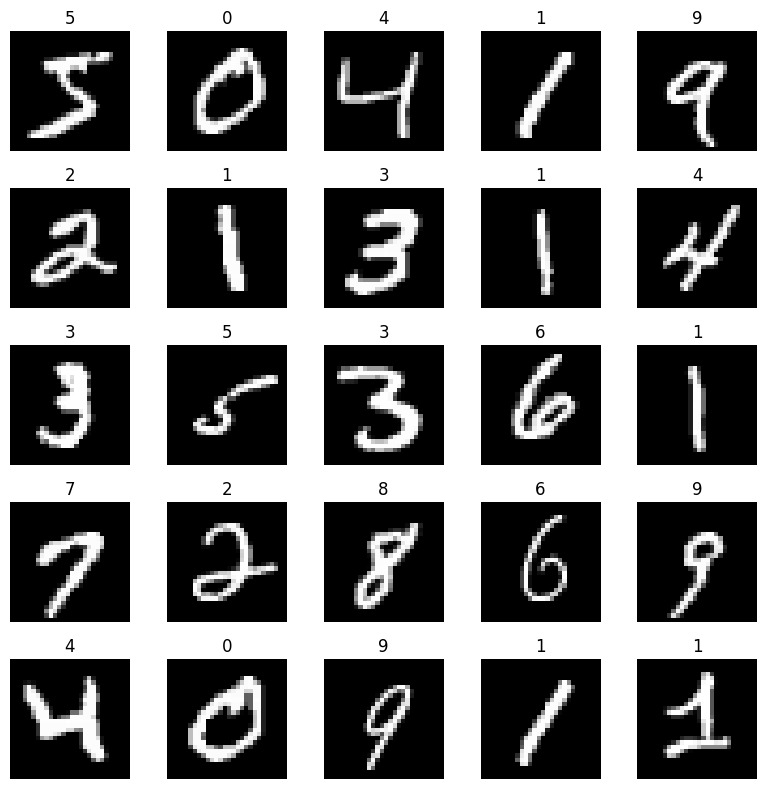

In [ ]:
def visualizar_imagenes(x, y, num_imagenes=100):
    """
    Visualiza imágenes del conjunto de datos MNIST en una matriz de 10x10.

    Parámetros:
    x (numpy array): Conjunto de imágenes.
    y (numpy array): Etiquetas correspondientes.
    num_imagenes (int): Número de imágenes a visualizar (debe ser un múltiplo de 10 para una grilla de 10x10).
    """
    num_filas = num_columnas = 5
    plt.figure(figsize=(8, 8))
    for i in range(num_imagenes):
        plt.subplot(num_filas, num_columnas, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap='gray')
        plt.title(f'{y[i].argmax()}', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con el conjunto de entrenamiento
visualizar_imagenes(X_train, y_train, num_imagenes=25)

Parece que las imagenes se han importado correctamente y que las etiquetas concuerdan.

A partir de ahora el conjunto X_test va a ser utilizado unicamente en el apartado 3 cuando hayamos creado un modelo que sea mejor que todos los estudiados a continuacion.

Por tanto, para poder hacer validacion de alguna forma tenemos que subdibidir el conjunto de entrenamiento. En este caso no usaremos $Cross$ $Validation$, ¿por que? Las redes neuronales requieren de mucho tiempo de entrenamiento, hacer CV con este conjunto haria que entrenar a los modelos tomase muchisimo tiempo. Es por ese motivo que vamos a utilizar un $Holdout$ de un 80% de train y un 20% de validacion.

In [ ]:
from sklearn.model_selection import train_test_split

# Creamos el conjunto de holdout y de validacion
X_holdout, X_val, y_holdout, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Mostramos las dimensiones de los conjuntos
print('X_holdout shape:', X_holdout.shape)
print(X_holdout.shape[0], 'train samples')
print('X_val shape:', X_val.shape)
print(X_val.shape[0], 'validation samples')

X_holdout shape: (48000, 28, 28, 1)
48000 train samples
X_val shape: (12000, 28, 28, 1)
12000 validation samples


Ahora que ya hemos definido nuestra estructura $Holdout$ vamos a definir nuestro primer modelo, el cual viene definido por la siguiente arquitectura ya dada.

Capas del Modelo:

- Conv2D: Capa convolucional con 32 filtros, cada uno de tamaño 3x3. El padding es "same" (mantiene el tamaño de la entrada). Parámetros: (3x3x1+1)x32 = 320.
- MaxPooling2D: Capa de pooling con tamaño 2x2, reduce las dimensiones a la mitad.
- Conv2D: Segunda capa convolucional con 16 filtros, cada uno de tamaño 5x5. El padding es "valid" (sin padding). Parámetros: (5x5x32+1)x16 = 12,816.
- MaxPooling2D: Segunda capa de pooling con tamaño 2x2, reduce nuevamente las dimensiones a la mitad.
- Flatten: Convierte las dimensiones en un vector unidimensional.
- Dense: Capa completamente conectada con 100 neuronas. Parámetros: 400x100 + 100 = 40,100.
- Dense: Segunda capa completamente conectada con 50 neuronas. Parámetros: 100x50 + 50 = 5,050.
- Dense: Capa de salida con 10 neuronas (correspondiente a las 10 clases de MNIST). Parámetros: 50x10 + 10 = 510.

In [ ]:
# Definicion del modelo
def crear_modelo_1():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(16, kernel_size=(5, 5), padding="valid", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  return model

Comprobamos que todo este en orden y que el modelo se haya creado de forma correcta.

In [ ]:
model = crear_modelo_1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        12816     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 100)               4

Como podemos ver el modelo se ha creado correctamente, con los parametros calculados anteriormente y todo parece estar en orden.

Ahora tenemos hay que establecer que hiperparametros utilizamos para entrenar el modelo. Esto nos genera un problema. Entrenar el modelo con los datos de holdout tardara unos 5 minutos mas o menos. Si queremos probar por ejemplo 27 permutaciones de batch size, epochs y learning rate, tardara unas 2 horas, si ademas esto lo queremos hacer con varios modelos, puede complicarse el poder entregar la practica a tiempo.

Por eso, dentro del 80% de holdout, vamos a tomar un 20% de este (un 16% del total), y ajustar los hiperparametros sobre este conjunto "X_hyper". Esto no es ideal pues estamos reduciendo mucho el tamaño del conjunto de datos, y es posible que nuestras estimaciones no se generalicen al conjunto en global, pero es lo mejor que podemos hacer.


In [ ]:
# Creamos un conjunto para poder ajustar los hiperparametros de forma menos costosa
_, X_hyper, _, y_hyper = train_test_split(X_holdout, y_holdout, test_size=0.2, random_state=42)
print('X_hyper shape:', X_hyper.shape)
print(X_hyper.shape[0], 'train samples')

X_hyper shape: (9600, 28, 28, 1)
9600 train samples


Una vez definido este conjunto, la siguiente funcion sirve para instanciar un modelo de red neuronal dados un batch_size, epochs, learning_rate. Esto servira a continuacion para poder probar distintas configuraciones.

In [ ]:
# Esta funcion sirve para evaluar un modelo creado por la funcion model_fn dados distintos hiperparametros
def train_and_evaluate(model_fn, X, y, batch_size, epochs, learning_rate, early_stopping,
                       optimizer_choice=None, input_shape=None):

    # Definimos el modelo con una forma concreta o generica
    if input_shape==None:
      modelo_prueba = model_fn()
    else:
      modelo_prueba = model_fn(input_shape)

    # Definimos el optimizer, para asi luego poder evaluar varios
    if optimizer_choice == 'AdamW':
        optimizer = AdamW(learning_rate=learning_rate)
    else:  # Adadelta
        optimizer = Adadelta(learning_rate=learning_rate)

    # Compilamos el modelo
    modelo_prueba.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenamos el modelo
    history = modelo_prueba.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0,
                        validation_split=(0.2), shuffle=True, callbacks=[early_stopping])

    # Evaluamos el modelo con el conjunto final
    test_loss, test_acc = modelo_prueba.evaluate(X, y, verbose=1)

    # Devolvemos la acc y el historial
    return test_acc, history

A continuacion, utilizando la funcion anterior vamos a probar 3 valores de batch_size, epochs, learning_rate, para poder estimar que valores son los mejores cuando afrontemos el problema. Como optimizador, en primer lugar utilizaremos Adadelta, y mas adelante veremos cuales son los efectos de usar AdamW y por que pasa asi.

Vamos a primero definir algunos conceptos:
- Batch_size: Es la cantidad de ejemplos del dataset que se van a pasar por la red neuronal antes de aplicar SGD.
- Epochs: Es el numero de veces que el modelo se va a entrenar con el conjunto de datos.
- Learning rate: Representa la "velocidad" o el "impulso" con el que aprende el modelo, un learning rate muy bajo hara que el modelo aprenda muy lento, y uno muy alto puede hacer que el modelo no aprenda o que incluso diverja.
- Optimizer: El optimizador es un componente crucial que ajusta los pesos del modelo para minimizar la función de pérdida. En términos simples, el optimizador guía el proceso de aprendizaje del modelo.
- Adadelta: se trata de un optimizador que modifica el learning rate de forma adaptativa (ADAptative DELTA), como el learning rate va disminuyendo con cada epoch, es posible que mayores learning rates den mejores resultados.
- AdamW: Se trata de un modelo que intenta corregir el problema del Weight Decay. Como el learning rate no se adapta, es probable que rates mas bajos den mejores resultados.

Como el optimizer esta tan relacionado con el funcionamiento del modelo, vamos a ajustar 2 modelos, uno con Adadelta y otro con AdamW. Empecemos por Adadelta, vamos a probar 3 valores de cada uno de los hiperparametros nombrados.

In [ ]:
# Tarda unos 10 minutos en ejecutar
keras.utils.set_random_seed(42)

# Definimos el "grid" de hiperparametros
batch_sizes = [32, 64, 128]
epochs_list = [20, 30, 40]
learning_rates = [0.001, 0.01, 0.1]

# Definimos un early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Guardamos los resultados y el historial para poder visualizarlos
test_acc_list_adadelta = []
histories_adadelta = []

# Recorremos el grid, entrenando a un modelo con cada grupo del grid posible (27 en total)
for b_s in batch_sizes:
  for epochs in epochs_list:
    for lr in learning_rates:
      t_a, h = train_and_evaluate(crear_modelo_1, X_hyper, y_hyper, batch_size=b_s,
                                  epochs=epochs, learning_rate=lr,early_stopping=early_stopping)

      test_acc_list_adadelta.append(t_a)
      histories_adadelta.append(h)

300/300 [==============================] - 1s 3ms/step - loss: 0.0620 - accuracy: 0.9829


Lo logico ahora seria quedarse con el modelo que mejores resultados haya dado, sin embargo hay que tener en cuenta que es posible que por el inicio aleatorio uno haya salido mejor que otro simplemente por suerte. De esta forma lo que haremos sera ver los 9 mejores y ver que hiperparametros son los mas repetidos dentro de estos para asi estimar cual puede llegar a ser mejor.

Vamos ademas a visualizar las curvas de aprendizaje para ver si encontramos alguna anomalia.

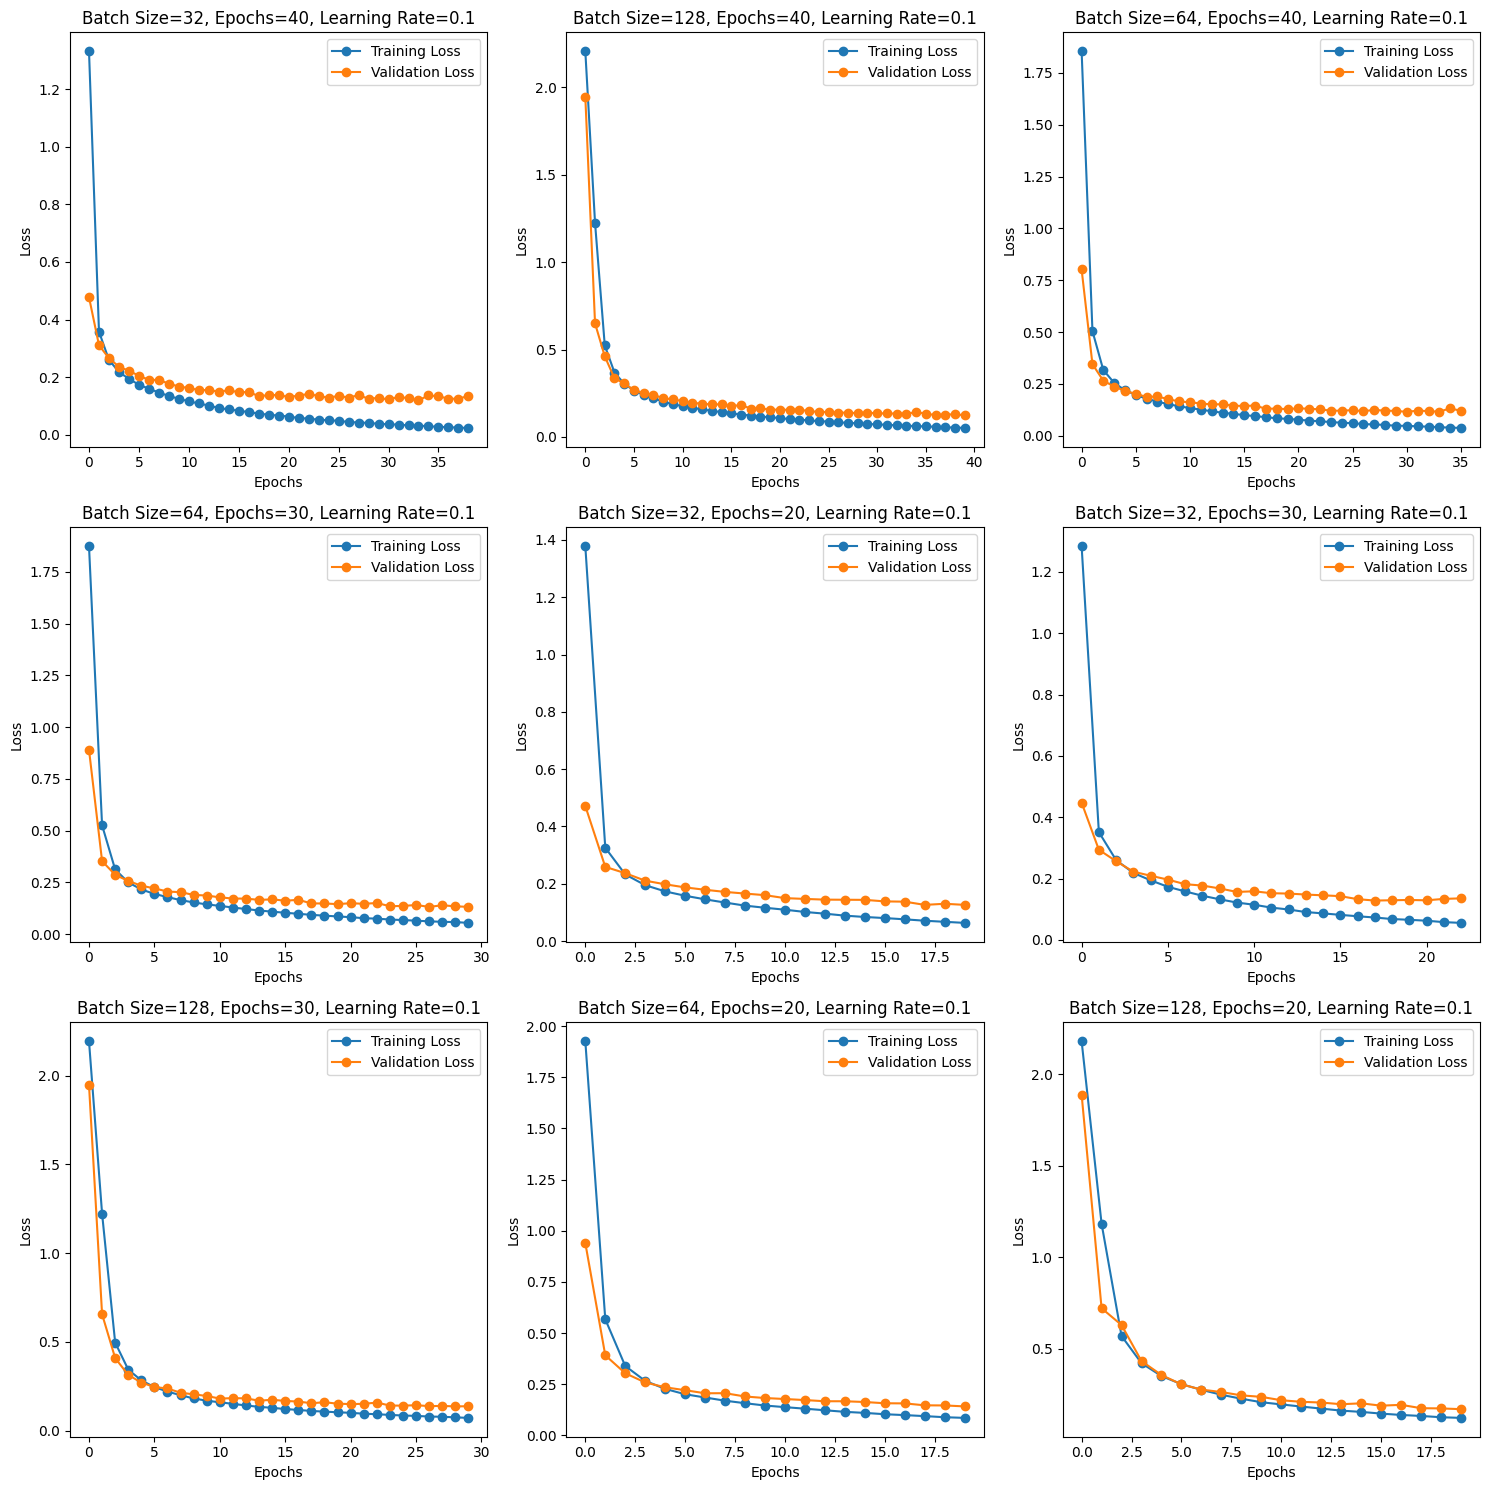

In [ ]:
# Este codigo lo ha hecho chatgpt, basicamente muestra las curvas obtenidas
# de los 9 mejores modelos
#----------------------------------------------------------------------
# Sort test_acc_list indices based on test accuracy in descending order
top_indices = np.argsort(test_acc_list_adadelta)[::-1][:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plot loss curves and show history for the top 9 best performing hyperparameter combinations
for i, idx in enumerate(top_indices):
    h = histories_adadelta[idx]
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.plot(h.history['loss'], label='Training Loss', marker="o")
    ax.plot(h.history['val_loss'], label='Validation Loss', marker="o")
    ax.set_title(f'Batch Size={batch_sizes[idx//9]}, Epochs={epochs_list[(idx%9)//3]}, Learning Rate={learning_rates[idx%3]}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()
#----------------------------------------------------------------------

Por lo tanto, de forma experimental y empirica nos quedamos con batch size 64, epochs 40 y learning rate de 0.1. Hay que tener en cuenta que el numero de epochs es un poco arbitrario, pues estamos usando early stopping, de todas formas siempre esta bien poner un limite superior por si acaso.

Ahora toca entrenar al modelo entero, con los datos de holdout y validar con los datos de validacion para comprobar que el modelo aprende a generalizar correctamente.

Como hemos dicho antes, vamos a utilziar early stopping, antes lo hemos pasado por encima pero ahora vamos a explicar como funciona y para que sirve.

Early stopping es un mecanismo de regularizacion, que para el entrenamiento cuando no se ha mejorado el rendimiento en $x$ epochs. Esto se hace para evitar sobreajustes, recordemos que el modelo se entrena con los datos de train, no los de validacion, por lo tanto, si el modelo por ejemplo mejora en train, pero empeora en validacion, esta siendo sobreajustado y es momento de parar el entrenamiento.

Por este motivo nosotros usamos ahora un early stopping con $x$ = $5$.

In [ ]:
keras.utils.set_random_seed(42)

# Definimos nuestro early stopping para que se quede con el mejor modelo encontrado
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Creamos el modelo
modelo_1_adadelta = crear_modelo_1()

# Definimos optimizer y modelo con sus respectivos hiperparametros
optimizer = Adadelta(learning_rate=0.1)
modelo_1_adadelta.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Entrenamos el modelo con los datos de holdout y validacion
history_adadelta = modelo_1_adadelta.fit(X_holdout, y_holdout, epochs=40, batch_size=32, verbose=1,
                    validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/40
1500/1500 [==============================] - 13s 8ms/step - loss: 0.4317 - accuracy: 0.8660 - val_loss: 0.1782 - val_accuracy: 0.9473
Epoch 2/40
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1513 - accuracy: 0.9551 - val_loss: 0.1222 - val_accuracy: 0.9634
Epoch 3/40
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1161 - accuracy: 0.9650 - val_loss: 0.0998 - val_accuracy: 0.9714
Epoch 4/40
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0959 - accuracy: 0.9711 - val_loss: 0.0858 - val_accuracy: 0.9740
Epoch 5/40
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0822 - accuracy: 0.9755 - val_loss: 0.0839 - val_accuracy: 0.9737
Epoch 6/40
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0734 - accuracy: 0.9774 - val_loss: 0.0702 - val_accuracy: 0.9808
Epoch 7/40
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0667 - accuracy: 0.9791 - val_loss: 0.0690 - val_accuracy

Vemos que el modelo ha conseguido generalizar de forma correcta y no parece haber sobreaprendido. Sabemos esto pues val_accuracy es muy parecido siempre a accuracy. Ademas podemos intuir que MNIST no es un problema muy dificil, pues apenas sin esfuerzo hemos conseguido buenos resultados.

A continuacion, vamos a utilizar esta funcion para visualizar las curvas de aprendizaje de un modelo en especifico, en concreto vamos a ver 4 curvas: arriba estan las curvas de loss, abajo las de accuracy, a la izquierda las de train y a la derecha las de validacion.

In [ ]:
# Chatgpt, en general, todo lo que sea visualizar lo he hecho 100% usandolo
# En este caso hace lo que he escrito arriba asi que poco hay que comentar
#----------------------------------------------------------------------
# Access the history data
def mostrar_evolucion(hist):
  history_dict_adamw = hist.history

  # Extract loss and accuracy values
  metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

  # Create a 2x2 grid for the plots
  plt.figure(figsize=(12, 10))

  for i, metric in enumerate(metrics, start=1):
      plt.subplot(2, 2, i)

      plt.plot(history_dict_adamw[metric], marker="o",
              label='Training' if 'loss' in metric else 'Validation',
              color='b' if 'loss' in metric else 'r')

      plt.title(f"{metric.capitalize().replace('_', ' ')}")
      plt.xlabel('Epochs')
      plt.ylabel(metric.capitalize())
      # plt.legend()

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()
#----------------------------------------------------------------------

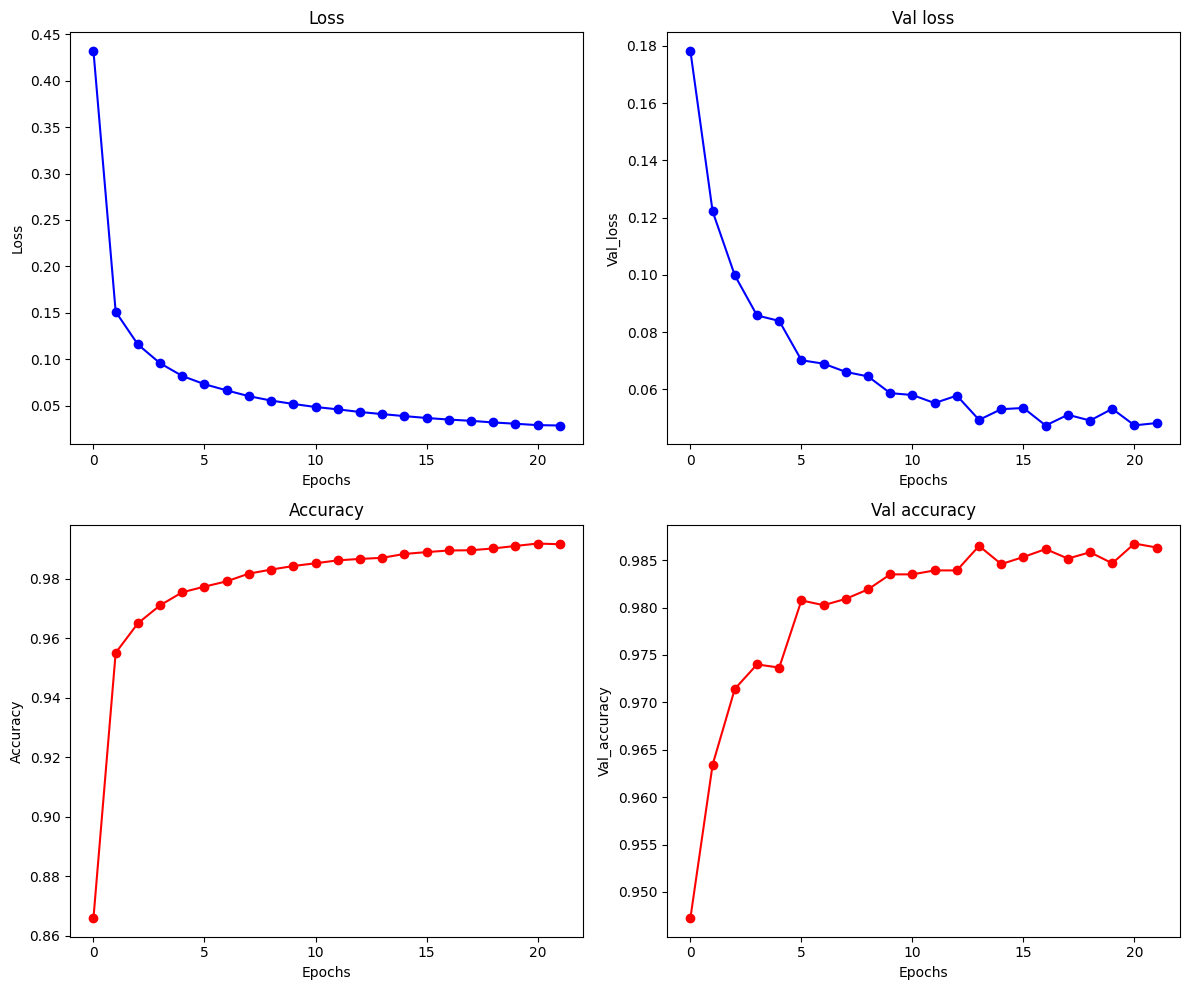

In [ ]:
mostrar_evolucion(history_adadelta)

Una cosa que no hemos mencionado anteriormente pero que ya podiamos saber, es que el early stopping ha saltado antes de que llegase a las 40 epochs, evitando asi un supuesto sobreajuste.

De los resultados obtenidos por 1 modelo no podemos decir mucho, lo que debemos hacer ahora es un modelo de comparacion, en este caso vamos a seguir paso a paso el mismo proceso que hemos seguido con Adadelta pero con AdamW. Primero seleccionar hiperparametros y luego entrenar con todo el conjunto.

In [ ]:
# Tarda unos 10 minutos en ejecutar
keras.utils.set_random_seed(42)

# Definimos el "grid" de hiperparametros
batch_sizes = [32, 64, 128]
epochs_list = [20, 30, 40]
learning_rates = [0.001, 0.01, 0.1]

# Definimos un early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

test_acc_list_adamw = []
histories_adamw = []
for b_s in batch_sizes:
  for epochs in epochs_list:
    for lr in learning_rates:
      t_a, h = train_and_evaluate(crear_modelo_1, X_hyper, y_hyper, batch_size=b_s,
                                  epochs=epochs, learning_rate=lr,early_stopping=early_stopping,
                                  optimizer_choice="AdamW")

      test_acc_list_adamw.append(t_a)
      histories_adamw.append(h)

300/300 [==============================] - 1s 3ms/step - loss: 2.3017 - accuracy: 0.1145


Para poder hablar mejor de los resultados vamos a visualizarlo y a ver que "cosas" se mantienen entre modelos.

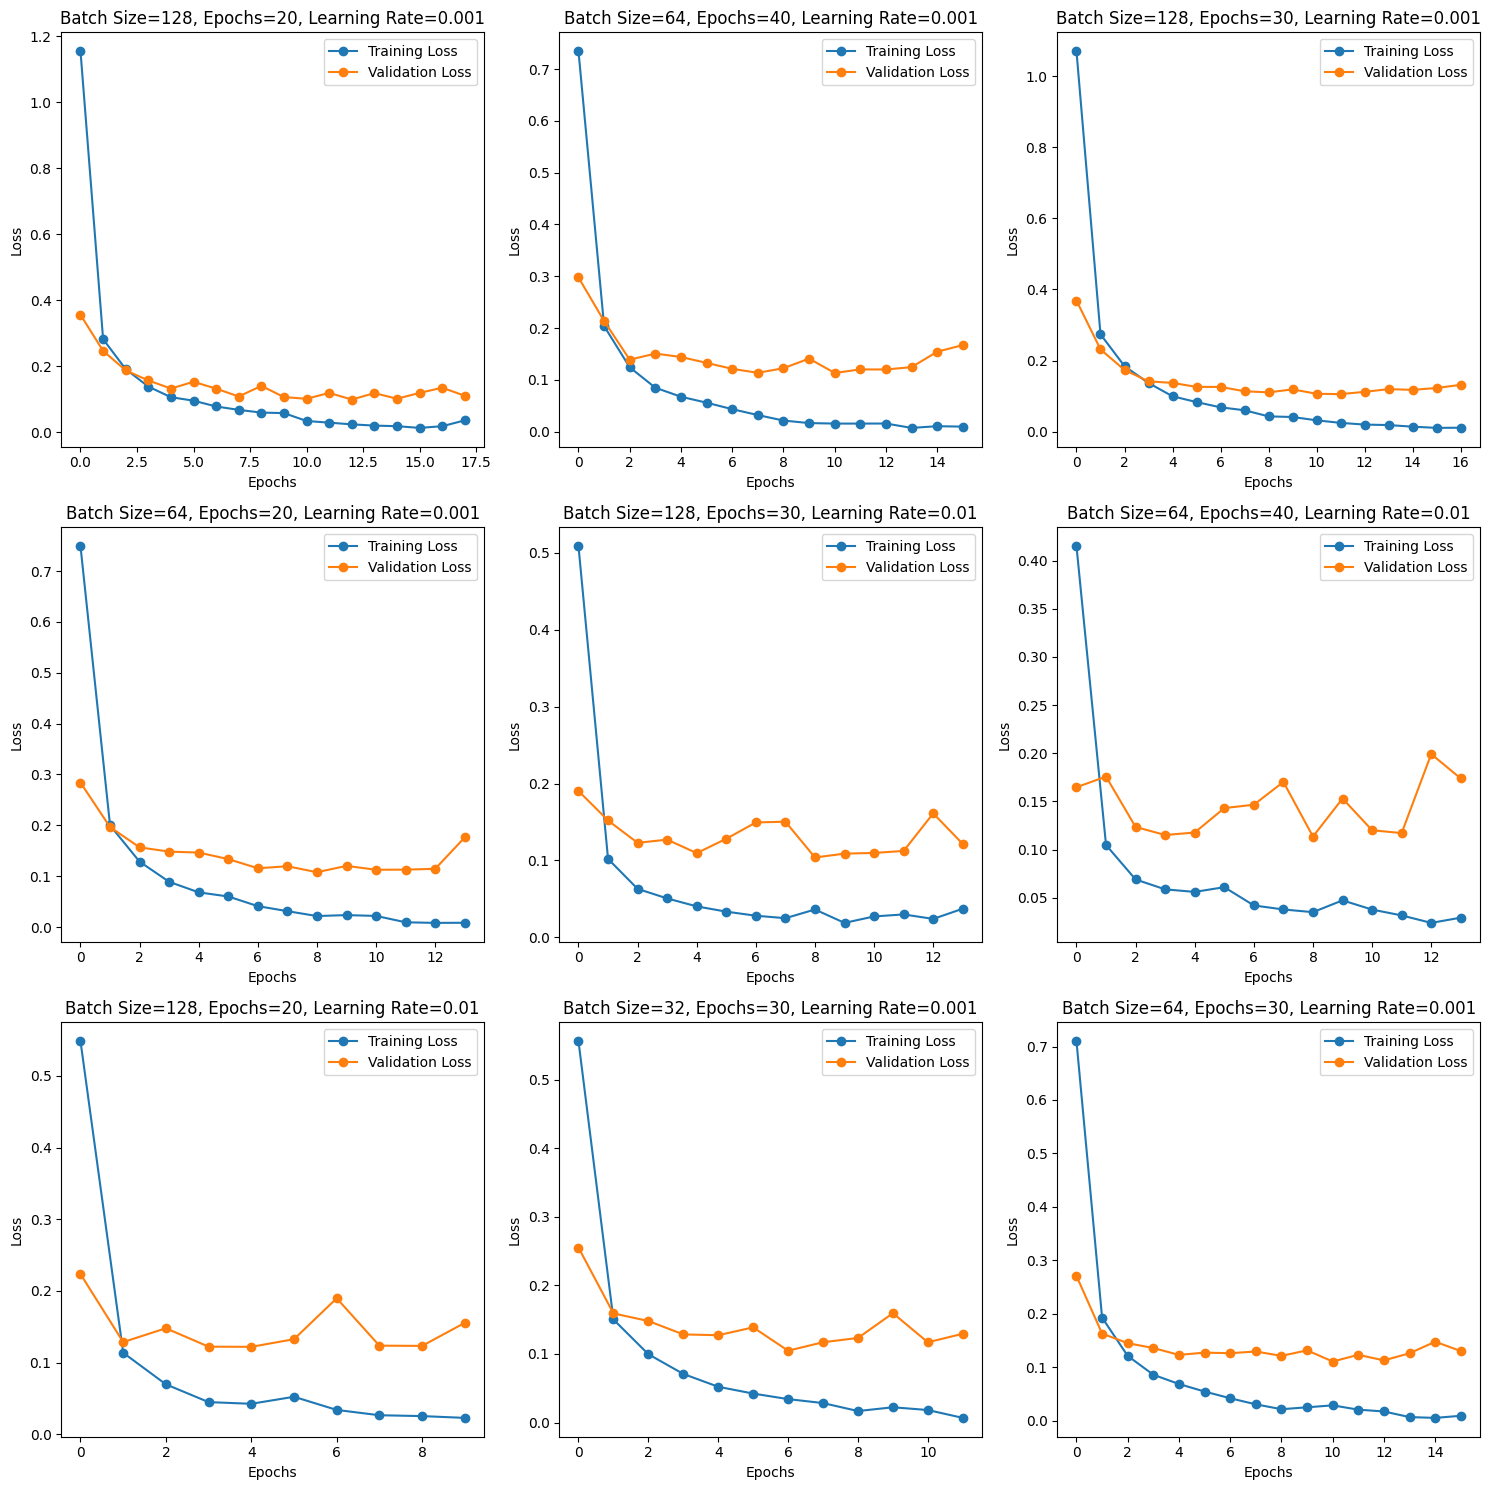

In [ ]:
# Sort test_acc_list indices based on test accuracy in descending order
top_indices_2 = np.argsort(test_acc_list_adamw)[::-1][:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plot loss curves and show history for the top 9 best performing hyperparameter combinations
for i, idx in enumerate(top_indices_2):
    h = histories_adamw[idx]
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.plot(h.history['loss'], label='Training Loss', marker="o")
    ax.plot(h.history['val_loss'], label='Validation Loss', marker="o")
    ax.set_title(f'Batch Size={batch_sizes[idx//9]}, Epochs={epochs_list[(idx%9)//3]}, Learning Rate={learning_rates[idx%3]}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

Como hemos intuido anteriormente, el learning rate "optimo" de AdamW tiende a ser menor que el de Adadelta, esto es por que Adadelta incluye un ajuste automatico del mismo mientras que AdamW no. Aunque este si incluye weight decay.

Otra cosa que vemos es que en este caso, tienden a dar mejores resultados Batch Sizes mas grandes, apareciendo solo 1 batch size de 32 en los 9 mejores.

Ademas vemos como de nuevo, el numero de epochs sirve de mas bien poco al usar early stopping, y nos queda claro que en general se hacen menos de 20.

Ahora vamos a construir el modelo con learning rate de 0.001, batch size de 128 y epochs de 20 (lo cual da igual claramente).

In [ ]:
keras.utils.set_random_seed(42)

# Definimos el modelo
modelo_1_adamw = crear_modelo_1()

# Definimos el early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Definimos optimizer y entrenamos con los hiperparametros pertinentes
optimizer = AdamW(learning_rate=0.001)
modelo_1_adamw.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_adamw = modelo_1_adamw.fit(X_holdout, y_holdout, epochs=20, batch_size=128, verbose=1,
                    validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/20
375/375 [==============================] - 5s 8ms/step - loss: 0.3211 - accuracy: 0.9006 - val_loss: 0.0922 - val_accuracy: 0.9714
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0811 - accuracy: 0.9751 - val_loss: 0.0663 - val_accuracy: 0.9807
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0568 - accuracy: 0.9826 - val_loss: 0.0482 - val_accuracy: 0.9854
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0436 - accuracy: 0.9866 - val_loss: 0.0528 - val_accuracy: 0.9838
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.0470 - val_accuracy: 0.9876
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.0431 - val_accuracy: 0.9867
Epoch 7/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0259 - accuracy: 0.9917 - val_loss: 0.0554 - val_accuracy: 0.9862
Epoch 

De nuevo, salta el early stopping pronto. Veamos las curvas de aprendizaje y discutamos los resultados.

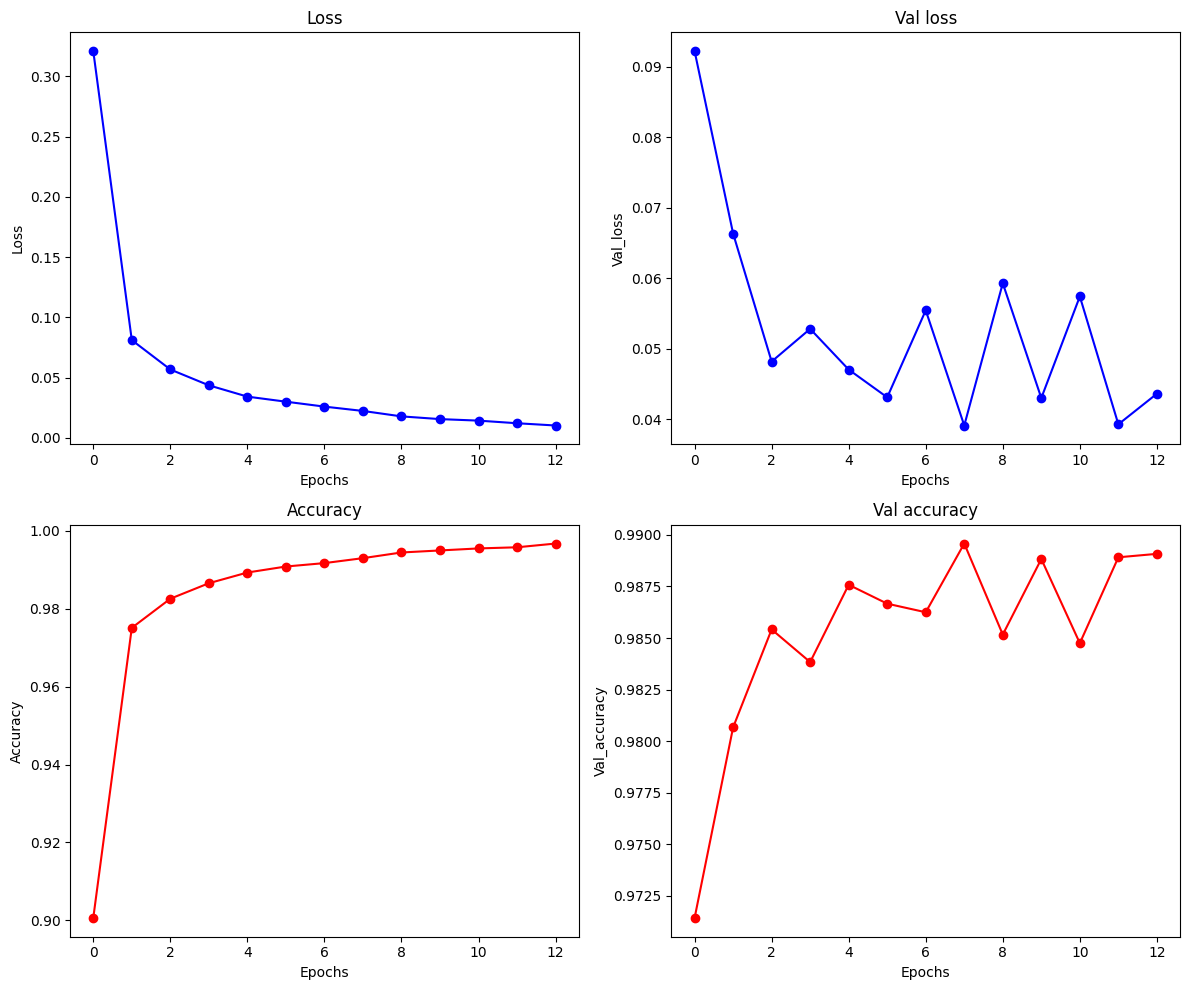

In [ ]:
mostrar_evolucion(history_adamw)

Podemos ver como AdamW y Adadelta dan resultados muy parecidos realmente, es cierto que en este caso AdamW ha dado "mejores resultados", no se si menos de un 1% de acc pueden considerarse mejores resultados teniendo en cuenta la aleatoriedad del inicio.

La gran diferencia si que la hemos visto en los parametros establecidos para cada uno, que son muy distintos.

Por ultimo entrenemos al modelo con el conjuto de test entero para ver que resultados conseguimos.

### Apartado 2: Implementación y experimentación con técnicas clásicas (características HOG y SVMs)

Ya hemos visto como una red neuronal es capaz de solucionar el problema MNIST, pero, como podemos saber que tan buena es si no tenemos nada con que compararla.

Vamos a entrenar un SVM utilizando las caracteristicas de HOG para ver como de bien podemos ajustarnos al problema con un enfoque clasico.

Antes de nada deberiamos explicar que son las caracteristicas de HOG

HOG (Histogram of Oriented Gradients) es una técnica de extracción de características que calcula gradientes de intensidad en celdas pequeñas, construye histogramas de orientaciones, normaliza estos histogramas en bloques superpuestos, y concatena los vectores resultantes para crear un descriptor robusto usado principalmente en la detección de objetos.

No vamos a entrar mucho en profundidad, pero digamos que eran un metodo muy popular dentro de la vision por computador hasta que llegaron las redes neuronales convolucionales. Vamos a calcularlas:

In [ ]:
from skimage.feature import hog

fd = hog(X_holdout[0], orientations=4, pixels_per_cell=(10,10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

X_holdout_HOG = np.zeros((X_holdout.shape[0],len(fd)), np.float32)
X_val_HOG = np.zeros((X_val.shape[0],len(fd)), np.float32)
X_hyper_HOG = np.zeros((X_hyper.shape[0],len(fd)), np.float32)

for i in range(X_holdout.shape[0]):
  X_holdout_HOG[i] = hog(X_holdout[i], orientations=4, pixels_per_cell=(10, 10),
                         cells_per_block=(2, 2), visualize=False, channel_axis=-1)

for i in range(X_val.shape[0]):
  X_val_HOG[i] = hog(X_val[i], orientations=4, pixels_per_cell=(10, 10),
                     cells_per_block=(2, 2), visualize=False, channel_axis=-1)

for i in range(X_hyper.shape[0]):
  X_hyper_HOG[i] = hog(X_hyper[i], orientations=4, pixels_per_cell=(10, 10),
                     cells_per_block=(2, 2), visualize=False, channel_axis=-1)

Para entrenar un SVM necesitamos que las etiquetas sean de una sola dimension, por lo tanto vamos a transformar las mismas en un vector donde el valor de cada indice corresponde con la clase. Tambien veremos la forma de todos los conjuntos resultantes.

In [ ]:
y_holdout_flat = y_holdout.argmax(axis=1)
y_val_flat = y_val.argmax(axis=1)
y_hyper_flat = y_hyper.argmax(axis=1)

print('X_holdout_HOG shape:', X_holdout_HOG.shape)
print('y_holdout_flat shape:', y_holdout_flat.shape)
print(X_holdout_HOG.shape[0], 'train samples')

print('X_val_HOG shape:', X_val_HOG.shape)
print('y_val_flat shape:', y_val_flat.shape)
print(X_val_HOG.shape[0], 'validation samples')


print('X_hyper_HOG shape:', X_hyper_HOG.shape)
print('y_hyper_flat shape:', y_hyper_flat.shape)
print(X_hyper_HOG.shape[0], 'train samples')

X_holdout_HOG shape: (48000, 16)
y_holdout_flat shape: (48000,)
48000 train samples
X_val_HOG shape: (12000, 16)
y_val_flat shape: (12000,)
12000 validation samples
X_hyper_HOG shape: (9600, 16)
y_hyper_flat shape: (9600,)
9600 train samples


Ahora vamos a estimar los hiperparametros de nuevo, la tecnica sera parecida a la anterior (un Grid Search), aunque claro al ser SVM menos costoso, podremos probar mas cosas.

In [ ]:
# Tarda unos 15 minutos solo con CPU

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

modelo_svm = SVC()

# Definir los parámetros que se van a probar
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 0.001, 0.01, 0.1]
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(modelo_svm, param_grid, cv=5, scoring='accuracy', n_jobs=1)

# Ajustar el modelo con la búsqueda en cuadrícula
grid_search.fit(X_hyper_HOG, y_hyper_flat)

# Obtener los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Resultado: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Mejores parámetros encontrados:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Que C haya salido 10 no me inspira mucha confianza, pues eso puede indicar que un valor mayor de C puede dar mejores resultados, por lo tanto vamos a probar el mejor modelo pero con varios valores de C mas altos para comprobar.

In [ ]:
# Tarda unos 50 segundos en ejecutar solo con CPU
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

modelo_svm = SVC(gamma="scale", kernel="rbf")

# Definir los parámetros que se van a probar
param_grid = {
    'C': [10, 30, 50, 70, 90],
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(modelo_svm, param_grid, cv=5, scoring='accuracy', n_jobs=1)

# Ajustar el modelo con la búsqueda en cuadrícula
grid_search.fit(X_hyper_HOG, y_hyper_flat)

# Obtener los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Mejores parámetros encontrados:
{'C': 10}


Vaya, parece ser que 10 era un valor muy bueno desde el principio. Perfecto ya tenemos nuestros hiperparametros calculados y establecidos, ahora vamos a aplicar este modelo a todo el conjunto de holdout.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score

modelo_svm = SVC(C=10, gamma="scale", kernel="rbf")
modelo_svm.fit(X_holdout_HOG, y_holdout_flat)


# Assuming X_val_HOG and y_val are the HOG features and labels for the validation set
svm_preds = modelo_svm.predict(X_val_HOG)

accuracy = accuracy_score(y_val_flat, svm_preds)
f1 = f1_score(y_val_flat, svm_preds, average="weighted")
precision = precision_score(y_val_flat, svm_preds, average='weighted')

print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Precision: 0.8613159880622905
Accuracy: 0.86075
F1-score: 0.8608389384684806


Aqui, precisamente es donde se ve la verdadera diferencia con las redes neuronales, una red neuronal sencilla como la que hemos hecho, sin regularizacion de ningun tipo y sin tener una estructura compleja ha consegido mejorar a SVM con caracteristicas de HOG en mas de un 10%. Es precisamente por eso que las redes neuronales convolucionales se han vuelto tan populares en esta rama de la ciencia de datos.

### Apartado 3: Implementación y experimentación con uno o más modelos escogidos o diseñados por los estudiantes

En este apartado tenemos mas libertad, asi que lo primero que voy a hacer es algo que tenia en mente desde el apartado 1. Reduccion de dimensionalidad, esta claro a simple vista que hay muchas columnas y filas que son innecesarias sobre todo en el exterior.

Voy a hacer un heatmap con 1000 imagenes superpuestas para ver si estoy en lo cierto.

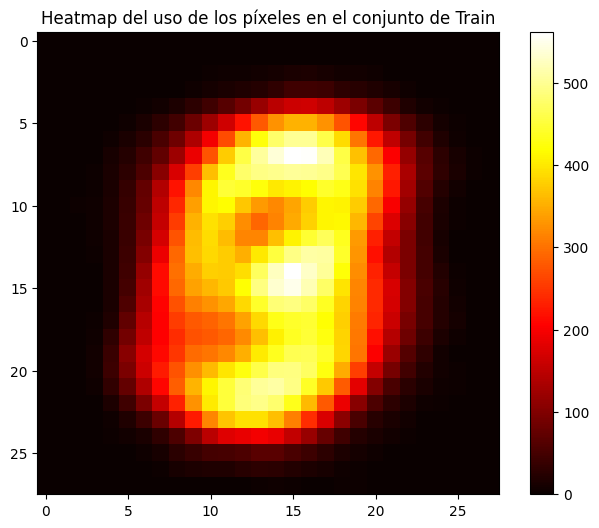

In [ ]:
# Seteamos la semilla
np.random.seed(42)

# Selecciona 100 índices aleatorios para las imágenes
indices_aleatorios = np.random.choice(len(X_holdout), size=1000, replace=False)

# Selecciona las imágenes correspondientes a los índices aleatorios
# imagenes_seleccionadas = imagenes_2d[indices_aleatorios]
imagenes_seleccionadas = X_holdout[indices_aleatorios]

# Cambiamos la forma para poder pintarlas
imagenes_seleccionadas = imagenes_seleccionadas.reshape(-1, 28, 28)

# Suma los valores de píxeles para cada posición en todas las imágenes seleccionadas
suma_pixeles = np.sum(imagenes_seleccionadas, axis=0)

# Crea un heatmap para visualizar qué píxeles son los menos usados
plt.figure(figsize=(8, 6))
plt.imshow(suma_pixeles, cmap='hot', interpolation='nearest')
plt.title('Heatmap del uso de los píxeles en el conjunto de Train')
plt.colorbar()
plt.show()

Efectivamente hay mucha informacion en los extremos de las imagenes que sobra y no aporta nada, vamos ahora a eliminar las 2 primeras y las 2 ultimas columnas y filas de las imagenes.

In [ ]:
# Eliminar las dos primeras filas y columnas, así como las dos últimas filas y columnas
X_test_recortado = X_test[:, 2:-2, 2:-2, :]
X_train_recortado = X_train[:, 2:-2, 2:-2, :]
X_holdout_recortado = X_holdout[:, 2:-2, 2:-2, :]
X_hyper_recortado = X_hyper[:, 2:-2, 2:-2, :]
X_val_recortado = X_val[:, 2:-2, 2:-2, :]

# Verificar la nueva forma
print("Forma original de X_holdout:", X_holdout.shape)
print("Nueva forma de X_holdout_recortado:", X_holdout_recortado.shape)

print("Forma original de X_hyper:", X_hyper.shape)
print("Nueva forma de X_hyper_recortado:", X_hyper_recortado.shape)

print("Forma original de X_val:", X_val.shape)
print("Nueva forma de X_val_recortado:", X_val_recortado.shape)

Forma original de X_holdout: (48000, 28, 28, 1)
Nueva forma de X_holdout_recortado: (48000, 24, 24, 1)
Forma original de X_hyper: (9600, 28, 28, 1)
Nueva forma de X_hyper_recortado: (9600, 24, 24, 1)
Forma original de X_val: (12000, 28, 28, 1)
Nueva forma de X_val_recortado: (12000, 24, 24, 1)


Con esto nuestro dataset es ahora un 21% mas pequeño y contiene practicamente la misma informacion, esto nos va a permitir que nuestro modelo tarde menos en entrenar sin sacrificar resultados.

Vamos a visualizar el mismo heatmap pero recortado para ver el resultado.

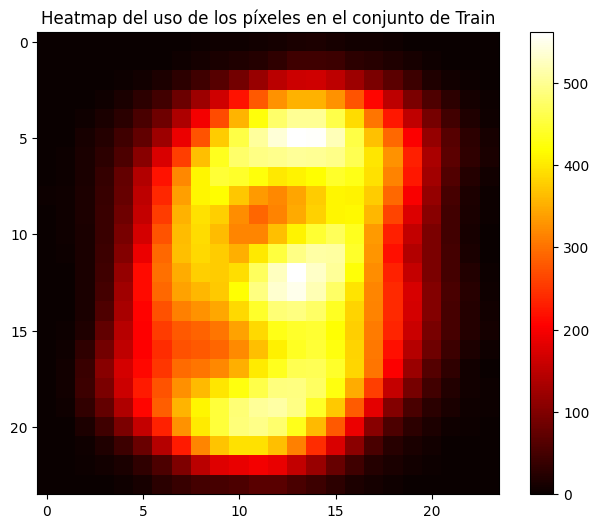

In [ ]:
# Seteamos la semilla
np.random.seed(42)

# Selecciona 100 índices aleatorios para las imágenes
indices_aleatorios = np.random.choice(len(X_holdout_recortado), size=1000, replace=False)

# Selecciona las imágenes correspondientes a los índices aleatorios
# imagenes_seleccionadas = imagenes_2d[indices_aleatorios]
imagenes_seleccionadas = X_holdout_recortado[indices_aleatorios]

# Cambiamos la forma para poder pintarlas
imagenes_seleccionadas = imagenes_seleccionadas.reshape(-1, 24, 24)

# Suma los valores de píxeles para cada posición en todas las imágenes seleccionadas
suma_pixeles = np.sum(imagenes_seleccionadas, axis=0)

# Crea un heatmap para visualizar qué píxeles son los menos usados
plt.figure(figsize=(8, 6))
plt.imshow(suma_pixeles, cmap='hot', interpolation='nearest')
plt.title('Heatmap del uso de los píxeles en el conjunto de Train')
plt.colorbar()
plt.show()

Sigue sobrando informacion, pero mucha menos.

Ahora vamos a definir nuestro nuevo modelo. Me gustaria haber sido mas original pero carezco de tiempo fisico asi que lo que voy a hacer es tomando el modelo primero como base, definir el mismo modelo, pero con las siguientes addiciones:
1. En primer lugar, mas filtros en las capas convolucionales y mas neuronas en las capas densas
2. Dropout, un proceso mediante el cual algunas neuronas se desactivan de forma aleatoria segun una probabilidad en el entrenamiento para que estas mismas tiendan a generalizar mejor.
3. Batch normalization, es una técnica utilizada para mejorar la velocidad, rendimiento y estabilidad del entrenamiento. Consiste en normalizar las activaciones de cada capa en mini-batches, de tal manera que tengan una media cercana a cero y una varianza cercana a uno.

De esta forma tenemos un modelo mas complejo, que permite valores mas altos de learning rate y que a su vez tiene varios mecanismos para evitar el sobreajuste.

In [ ]:
from keras.layers import BatchNormalization
from keras import regularizers

# Definimos el modelo 2
def crear_modelo_2(input_shape=(24, 24, 1)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu',
                     kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    return model

modelo_2 = crear_modelo_2(input_shape)
modelo_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)        1

Como dato que nos permita representar cuanto mas complejo es ete modelo en comparacion con el anterior, este tiene 7,7 veces mas parametros. Esto va a hacer que los entrenos tarden mas, pero como hemos apicado reduccion de dimensionalidad, espero que no sea algo dramatico.

Vamos a seguir ahora el mismo proceso de eleccion de hiperparametros que seguimos con la anterior red neuronal.

In [ ]:
keras.utils.set_random_seed(42)

batch_sizes = [32, 64, 128]
epochs_list = [20, 30, 40]
learning_rates = [0.001, 0.01, 0.1]

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

test_acc_list_adadelta = []
histories_adadelta = []
for b_s in batch_sizes:
  for epochs in epochs_list:
    for lr in learning_rates:
      t_a, h = train_and_evaluate(crear_modelo_2, X_hyper_recortado, y_hyper,
                                  batch_size=b_s, epochs=epochs, learning_rate=lr,
                                  early_stopping=early_stopping)

      test_acc_list_adadelta.append(t_a)
      histories_adadelta.append(h)

300/300 [==============================] - 1s 4ms/step - loss: 1.1198 - accuracy: 0.9839


Vamos a visualizar los resultados, y a escoger los mejores hiperparametros del modelo.

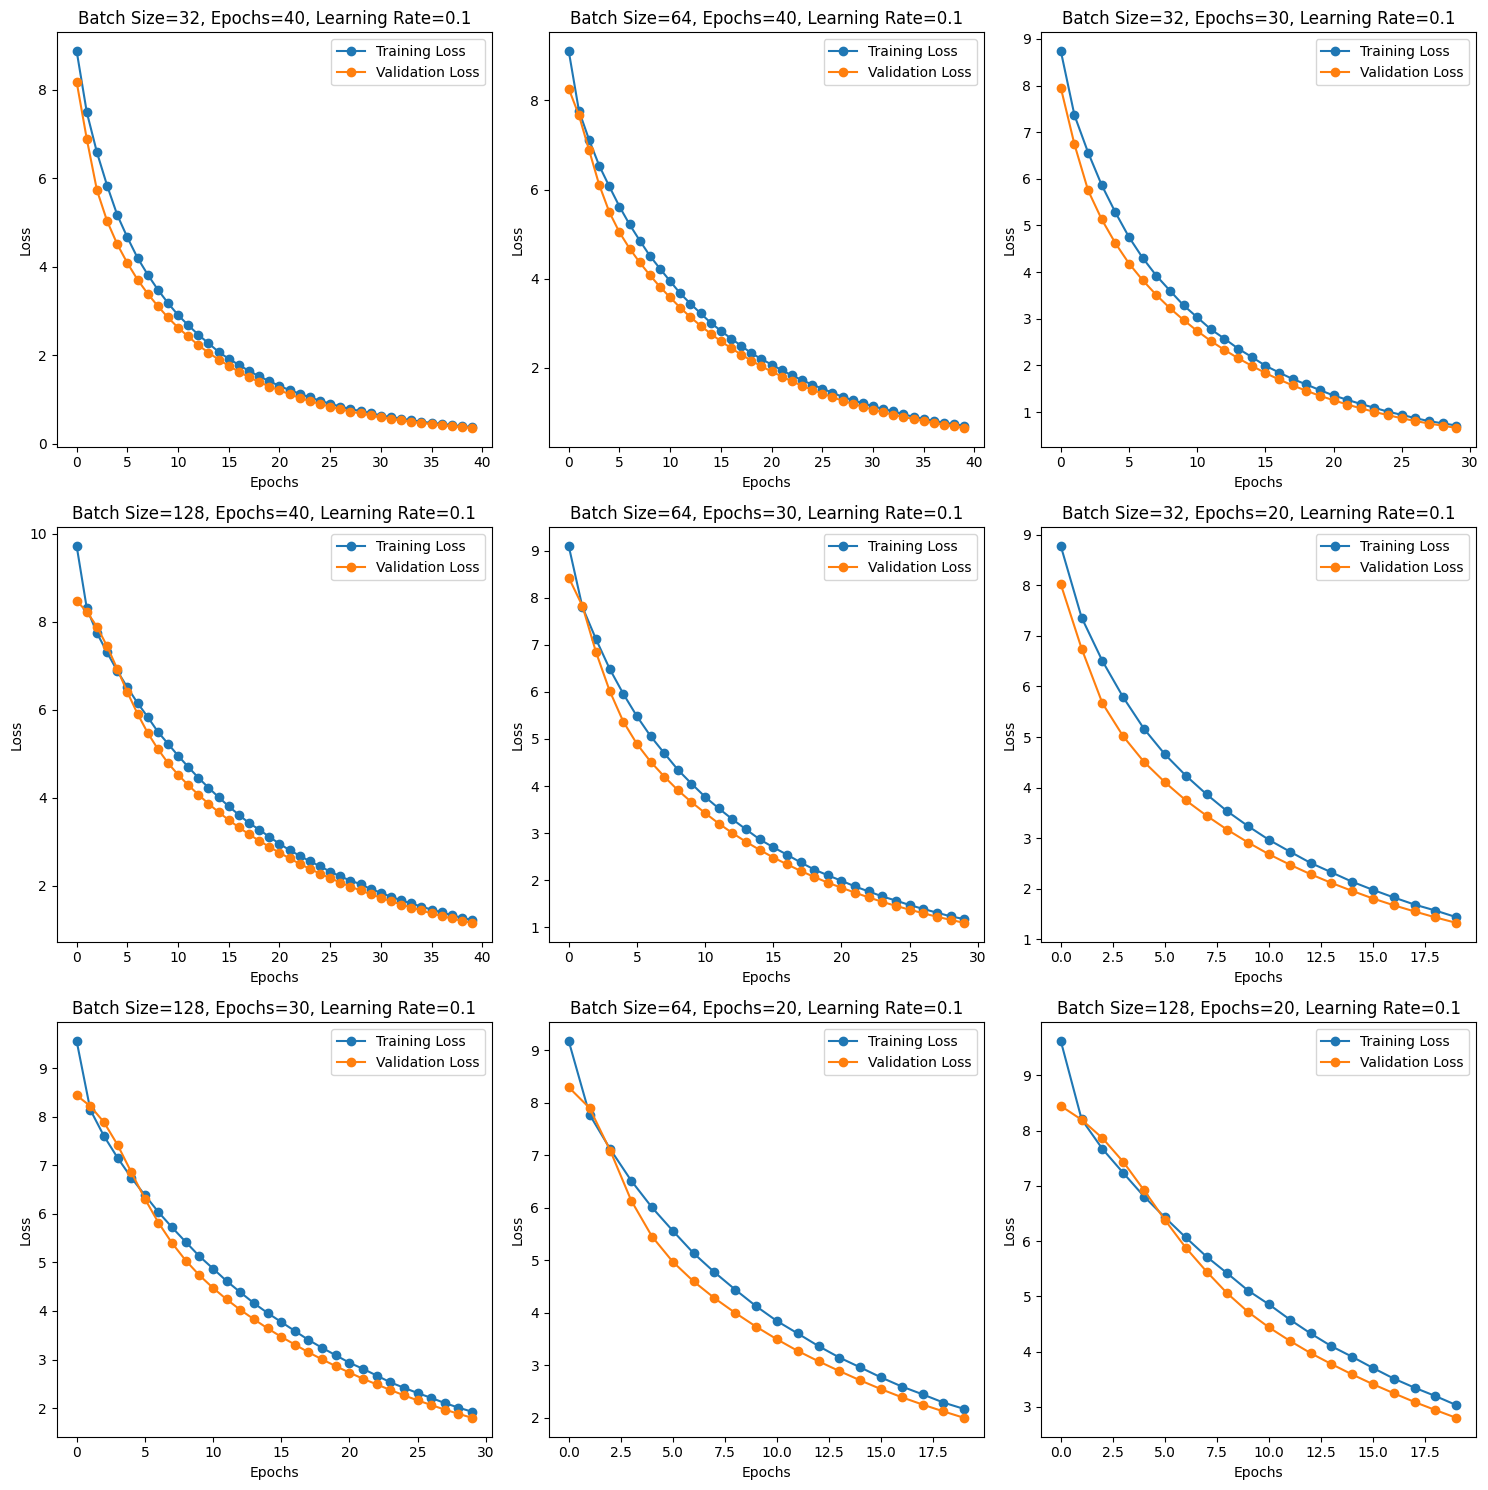

In [ ]:
# Sort test_acc_list indices based on test accuracy in descending order
top_indices = np.argsort(test_acc_list_adadelta)[::-1][:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plot loss curves and show history for the top 9 best performing hyperparameter combinations
for i, idx in enumerate(top_indices):
    h = histories_adadelta[idx]
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.plot(h.history['loss'], label='Training Loss', marker="o")
    ax.plot(h.history['val_loss'], label='Validation Loss', marker="o")
    ax.set_title(f'Batch Size={batch_sizes[idx//9]}, Epochs={epochs_list[(idx%9)//3]}, Learning Rate={learning_rates[idx%3]}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

En este caso, como ha pasado con SVM vemos que un learning rate de 0.1 ha sido mejor en los 9 mejores, lo cual me vuelve a llevar a sospechar que un mayor learning rate dara mejores resultados, ademas las curvas de aprendizaje parecen demasiado "suaves".

Por otro lado el batch size parece no haber afectado en nada, pues tenemos un gran mix de ellos en el top 9, y las epochs, tampoco parecen haber afectado demasiado, por lo tanto ahora vamos a probar distintos learning rates mas altos con batch size de 32 y 40 epochs.

In [ ]:
keras.utils.set_random_seed(42)

learning_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

test_acc_list_adadelta = []
histories_adadelta = []
for lr in learning_rates:
  t_a, h = train_and_evaluate(crear_modelo_2, X_hyper_recortado, y_hyper,
                              batch_size=32, epochs=40, learning_rate=lr,
                              early_stopping=early_stopping)

  test_acc_list_adadelta.append(t_a)
  histories_adadelta.append(h)

300/300 [==============================] - 1s 2ms/step - loss: 0.1739 - accuracy: 0.9897


Parece ser que el mejor learning rate es el segundo (0.3) por lo que de ahora en adelante sera el que utilcemos en eeste modelo.

Ahora vamos a entrenar al modelo con los hiperparametros calculados y ver que tal se ajusta al test tal y como esta ahora. Este modelo tambien lo entrenaremos mas adelante con TODO el conjunto (aunque sea data snooping) para ver que tan bien funciona, pero eso sera al final del apartado 3.

In [ ]:
keras.utils.set_random_seed(42)

modelo_2 = crear_modelo_2() # Reseteamos el modelo antes de entrenarlo

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

optimizer = Adadelta(learning_rate=0.3)
modelo_2.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_modelo_2 = modelo_2.fit(X_holdout_recortado, y_holdout, epochs=40, batch_size=32, verbose=1,
                    validation_data=(X_val_recortado, y_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/40
1500/1500 [==============================] - 12s 7ms/step - loss: 4.0383 - accuracy: 0.7849 - val_loss: 1.5427 - val_accuracy: 0.9728
Epoch 2/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9788 - accuracy: 0.9506 - val_loss: 0.4821 - val_accuracy: 0.9803
Epoch 3/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3873 - accuracy: 0.9671 - val_loss: 0.2439 - val_accuracy: 0.9831
Epoch 4/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2471 - accuracy: 0.9725 - val_loss: 0.1772 - val_accuracy: 0.9835
Epoch 5/40
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2047 - accuracy: 0.9754 - val_loss: 0.1598 - val_accuracy: 0.9835
Epoch 6/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1866 - accuracy: 0.9763 - val_loss: 0.1438 - val_accuracy: 0.9856
Epoch 7/40
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1755 - accuracy: 0.9766 - val_loss: 0.1355 - val_ac

Veamos ahora su curva de aprendizaje, para ver que todo ha estado en orden anque derberia estarlo debido a los metodos de regularizacion que estamos utilizando.

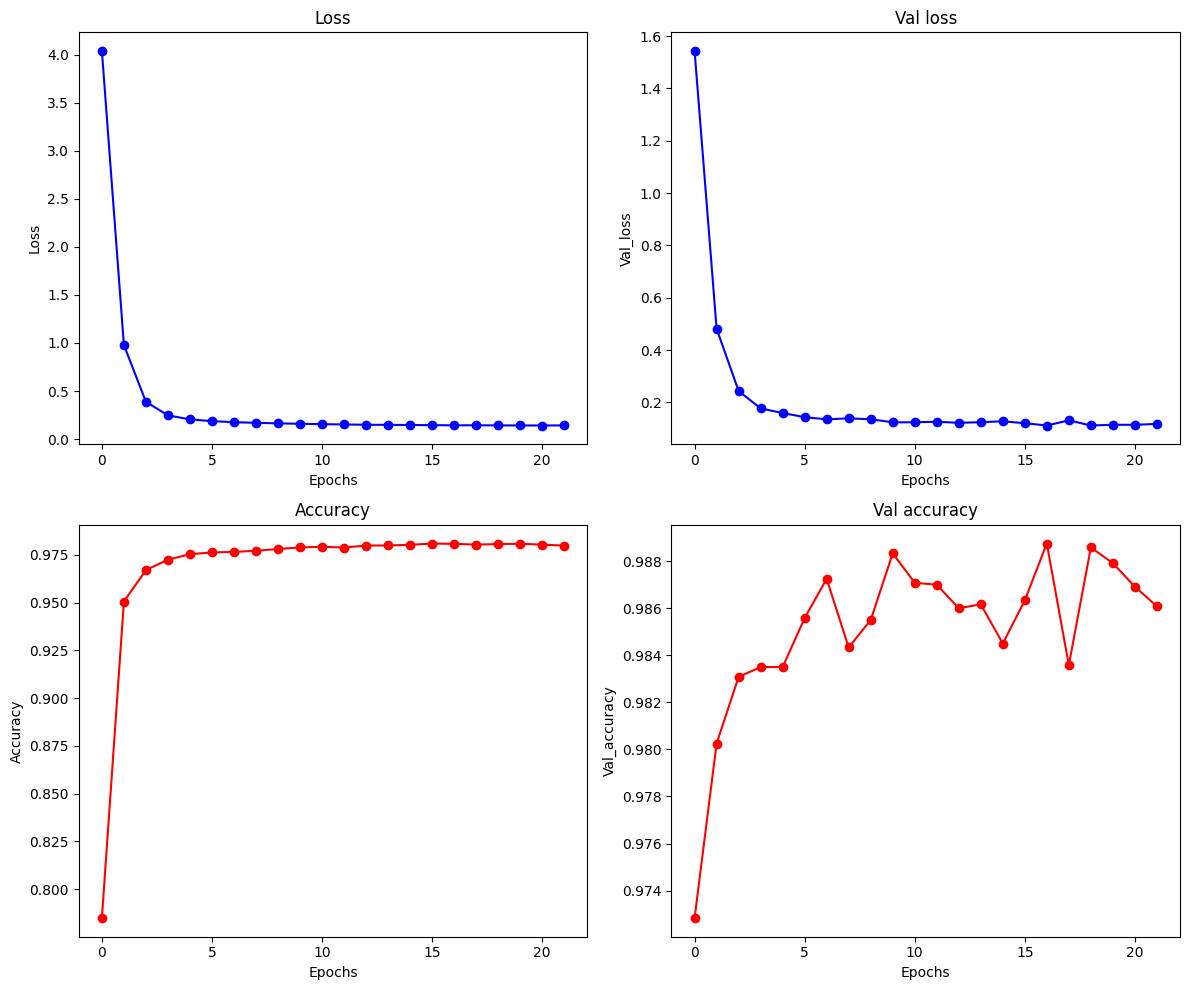

In [ ]:
mostrar_evolucion(history_modelo_2)

Como vemos, las curvas encontradas parecen razonables. Una cuestion a notar es que aunque en "Val accuracy" parezca que hay mucho "ruido" hay que tener en cuenta que el modelo en el peor resultado y en el mejor varia menos de un 3% por lo que es normal ver saltos tan "grandes" en la grafica.

Vamos ahora a aplicarlo a test y ver que resultados da.

In [ ]:
# Eliminar las dos primeras filas y columnas, así como las dos últimas filas y columnas
X_test_recortado = X_test[:, 2:-2, 2:-2, :]

# Verificar la nueva forma
print("Forma original de X_test:", X_test.shape)
print("Nueva forma de X_test_recortado:", X_test_recortado.shape)

Forma original de X_test: (10000, 28, 28, 1)
Nueva forma de X_test_recortado: (10000, 24, 24, 1)


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = modelo_2.evaluate(X_test_recortado, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.1056 - accuracy: 0.9893
Test Loss: 0.10559030622243881
Test Accuracy: 0.989300012588501


Como hemos visto, el problema MNIST es un problema relativamente sencillo, donde conseguir mas de un 98% en test de accuracy es sencillo. Por lo tanto ahora vamos a intentar solucionar un problema mas complejo como es CIFAR10

Este es bastante mas complejo que el anterior conteniendo 10 clases de imagenes representando cada una una cosa con imagenes a color.

In [ ]:
cifar10 = keras.datasets.cifar10

# Dividir los datos en entrenamiento y prueba
(X_train_c, y_train_c), (X_test_c, y_test_c) = cifar10.load_data()

y_train_c = to_categorical(y_train_c, num_classes=10)
y_test_c = to_categorical(y_test_c, num_classes=10)

# Clases en CIFAR-10
class_names = ['Avión', 'Coche', 'Pájaro', 'Gato', 'Ciervo',
               'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

print('X_train_c shape:', X_train_c.shape)
print(X_train_c.shape[0], 'train samples')
print('X_test_c shape:', X_test_c.shape)
print(X_test_c.shape[0], 'test samples')

170498071/170498071 [==============================] - 11s 0us/step
X_train_c shape: (50000, 32, 32, 3)
50000 train samples
X_test_c shape: (10000, 32, 32, 3)
10000 test samples


Lo primero que vamos a hacer es separar train en holdout y validacion para poder entrenar los modelos sin hacer data snooping y que comprobar que nuestro modelo no haga overfitting.

In [ ]:
X_holdout_c, X_val_c, y_holdout_c, y_val_c = train_test_split(X_train_c, y_train_c,
                                                              test_size=0.2, random_state=42)

_, X_hyper_c, _, y_hyper_c = train_test_split(X_holdout_c, y_holdout_c, test_size=0.2, random_state=42)


print('X_holdout_c shape:', X_holdout_c.shape)
print(X_holdout_c.shape[0], 'train samples')
print('y_holdout_c shape:', y_holdout_c.shape)
print(y_holdout_c.shape[0], 'train samples')
print('X_val_c shape:', X_val_c.shape)
print(X_val_c.shape[0], 'validation samples')
print('X_hyper_c shape:', X_hyper_c.shape)
print(X_hyper_c.shape[0], 'validation samples')

X_holdout_c shape: (40000, 32, 32, 3)
40000 train samples
y_holdout_c shape: (40000, 10)
40000 train samples
X_val_c shape: (10000, 32, 32, 3)
10000 validation samples
X_hyper_c shape: (8000, 32, 32, 3)
8000 validation samples


Una vez hecho esto, vamos a visualizar algunas imagenes para ver que todo se ha importado correctamente y tambien para ver cual es la naturaleza de las imagenes con las que nos enfrentamos.

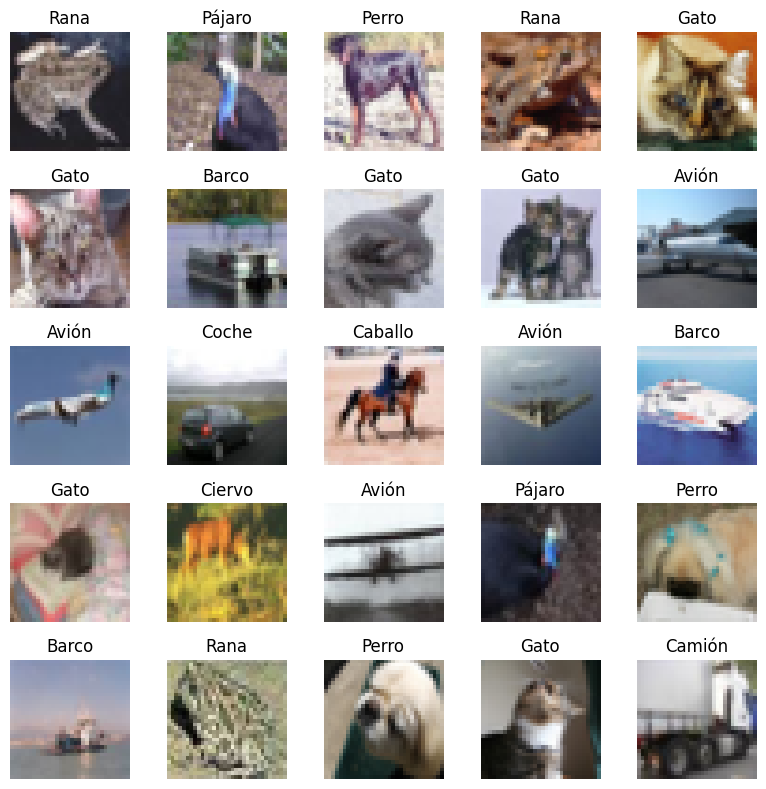

In [ ]:
def visualizar_imagenes(x, y, num_imagenes=25, class_names=None):
    """
    Visualiza imágenes del conjunto de datos CIFAR-10 en una matriz.

    Parámetros:
    x (numpy array): Conjunto de imágenes.
    y (numpy array): Etiquetas correspondientes.
    num_imagenes (int): Número de imágenes a visualizar (debe ser un múltiplo de 5 para una grilla de 5x5).
    """
    num_filas = num_columnas = int(num_imagenes**0.5)
    plt.figure(figsize=(8, 8))
    for i in range(num_imagenes):
        plt.subplot(num_filas, num_columnas, i + 1)
        plt.imshow(x[i])

        if class_names != None:
          plt.title(f'{class_names[y[i].argmax()]}', fontsize=12)
        else:
          plt.title(f'{y[i].argmax()}', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con el conjunto de entrenamiento
visualizar_imagenes(X_holdout_c, y_holdout_c, num_imagenes=25, class_names=class_names)

Como vemos este problema es mucho mas complejo que el anterior, en primer lugar las imagenes son bastante mas grandes (32x32), teniendo en cuenta que a nuestro anterior dataset le habiamos aplicado una reduccion de dimensionalidad (hasta dejarlo en 24x24) . Ademas ahora tenemos 3 canales de color, lo cual lo hace todo aun mas costoso.

Vamos ahora a entrenar el mismo modelo que teniamos antes, sin ajustar nada para ver cuales son los resultados obtenidos. Mas adelante ajustaremos los hiperparamteros para mejorar los resultados.

In [ ]:
keras.utils.set_random_seed(42)

modelo_cifar = crear_modelo_2(input_shape=(32, 32, 3)) # Reseteamos el modelo antes de entrenarlo

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

optimizer = Adadelta(learning_rate=0.3)
modelo_cifar.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_modelo_2 = modelo_cifar.fit(X_holdout_c, y_holdout_c, epochs=40, batch_size=32, verbose=1,
                    validation_data=(X_val_c, y_val_c), shuffle=True, callbacks=[early_stopping])

Epoch 1/40
1250/1250 [==============================] - 10s 6ms/step - loss: 5.5187 - accuracy: 0.2681 - val_loss: 2.9003 - val_accuracy: 0.4647
Epoch 2/40
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4005 - accuracy: 0.4733 - val_loss: 1.7723 - val_accuracy: 0.5902
Epoch 3/40
1250/1250 [==============================] - 8s 6ms/step - loss: 1.7562 - accuracy: 0.5672 - val_loss: 1.5063 - val_accuracy: 0.6271
Epoch 4/40
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5295 - accuracy: 0.6062 - val_loss: 1.3889 - val_accuracy: 0.6461
Epoch 5/40
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4285 - accuracy: 0.6296 - val_loss: 1.6093 - val_accuracy: 0.5753
Epoch 6/40
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3768 - accuracy: 0.6458 - val_loss: 1.3716 - val_accuracy: 0.6380
Epoch 7/40
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3367 - accuracy: 0.6551 - val_loss: 1.4020 - val_accuracy

Como podemos ver, este problema parece ser mucho mas complejo que el anterior en el que obteniamos un +97% sin esfuerzo, mi objetivo va a ser superar claramente el 70% de acc en test.

 Vamos a ajustar de nuevo los hiperparametros para este problema. El proceso vaa a ser muy similar (por no decir el mismo) al que seguimos anteriormente.

In [ ]:
keras.utils.set_random_seed(42)

batch_sizes = [32, 64, 128]
epochs_list = [20, 30, 40]

# Lo mas probable es que 0.01 sea muy bajo, pero vamos a probar igual
learning_rates = [0.01, 0.1, 0.5]

# Tambien se han probado estos, pero a partir de 0.5 empeora
#learning_rates = [0.5, 0.7, 1]

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

test_acc_list_adadelta = []
histories_adadelta = []
for b_s in batch_sizes:
  for epochs in epochs_list:
    for lr in learning_rates:
      t_a, h = train_and_evaluate(crear_modelo_2, X_hyper_c, y_hyper_c,
                                  batch_size=b_s, epochs=epochs, learning_rate=lr,
                                  early_stopping=early_stopping, input_shape=(32, 32, 3))

      test_acc_list_adadelta.append(t_a)
      histories_adadelta.append(h)

250/250 [==============================] - 1s 4ms/step - loss: 0.9839 - accuracy: 0.8575


Algunos de estos modelos estan consiguiendo mas de un 75% de accuracy aunque claro, el dataset es mucho mas pequeño.

Ahora visualizamos las curvas de aprendizaje de los mejores 9 modelos para ver que resultados da cada combinacion.

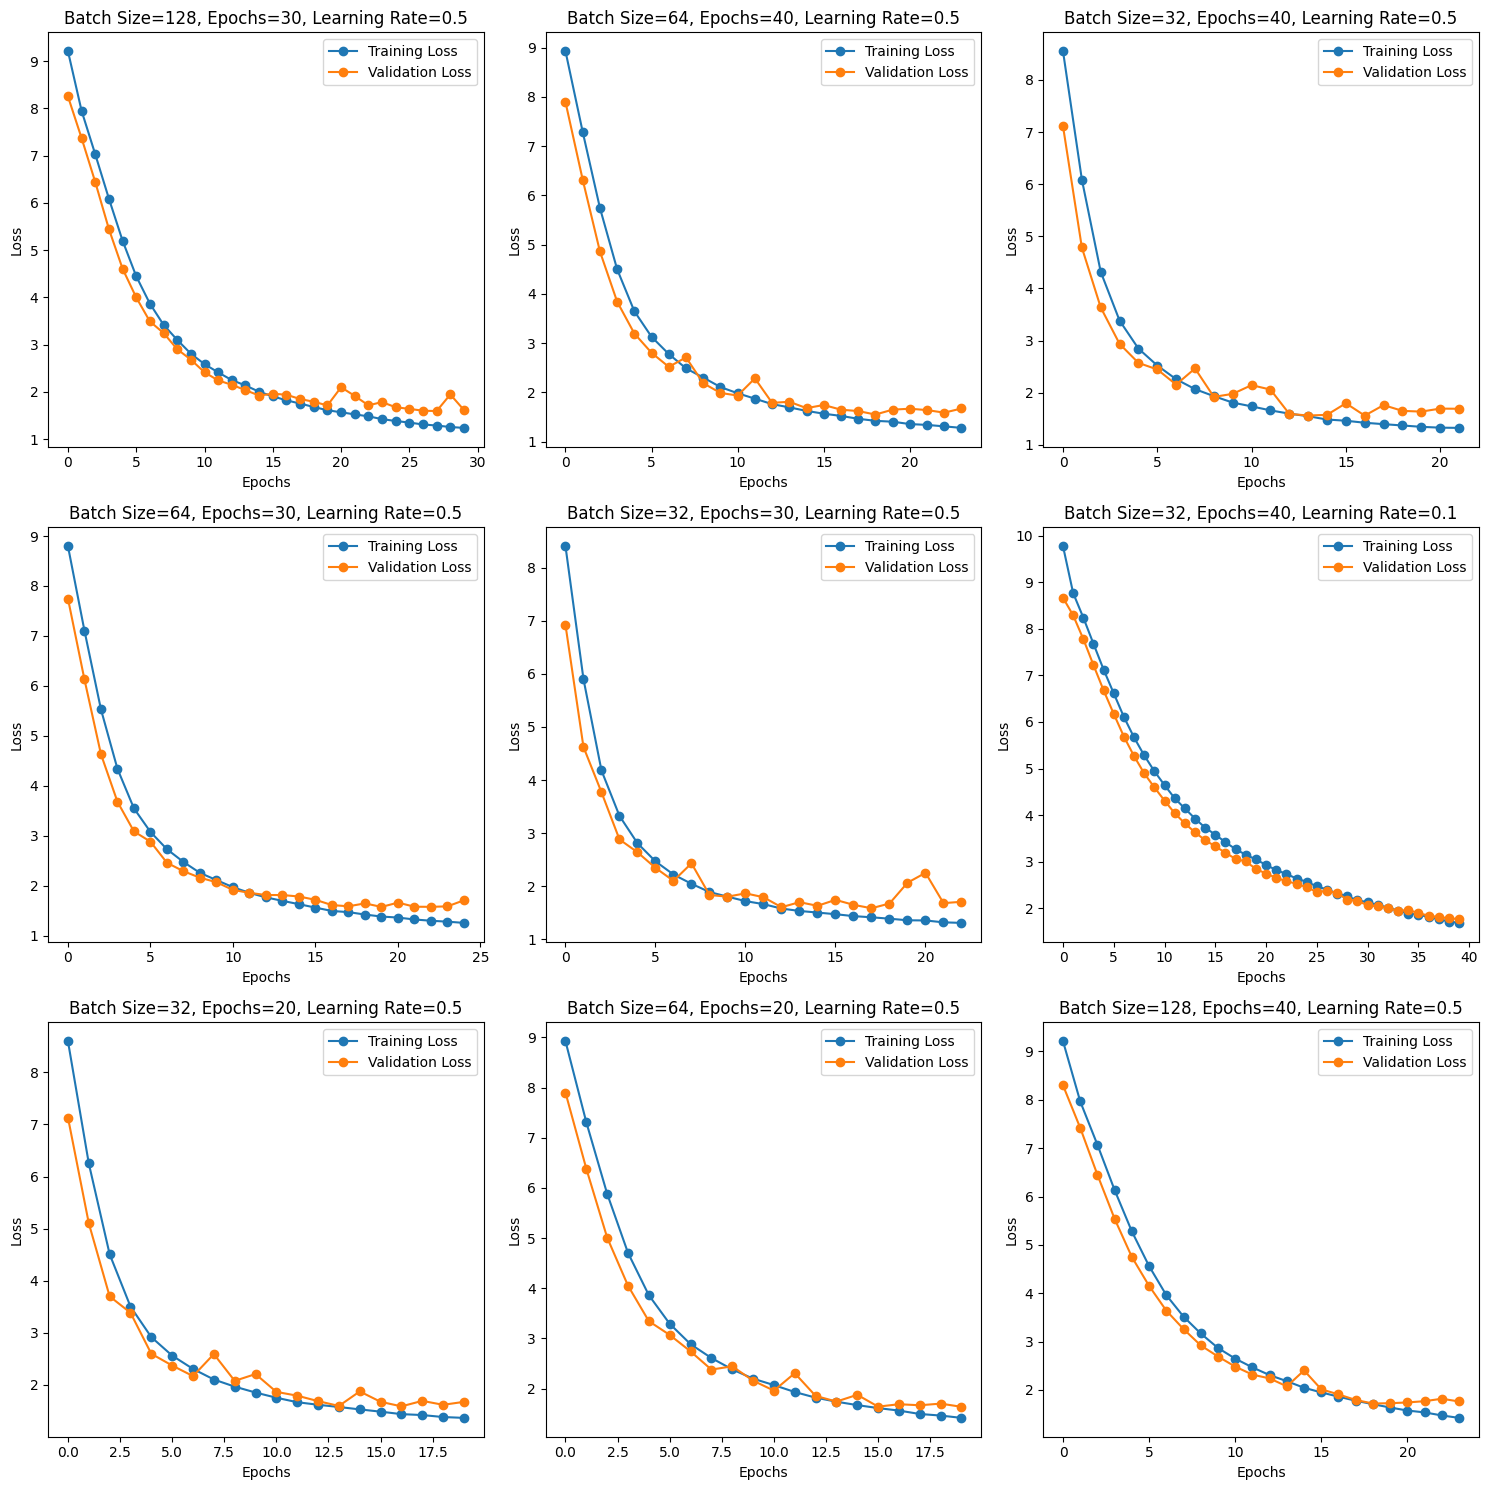

In [ ]:
top_indices = np.argsort(test_acc_list_adadelta)[::-1][:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plot loss curves and show history for the top 9 best performing hyperparameter combinations
for i, idx in enumerate(top_indices):
    h = histories_adadelta[idx]
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.plot(h.history['loss'], label='Training Loss', marker="o")
    ax.plot(h.history['val_loss'], label='Validation Loss', marker="o")
    ax.set_title(f'Batch Size={batch_sizes[idx//9]}, Epochs={epochs_list[(idx%9)//3]}, Learning Rate={learning_rates[idx%3]}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

De nuevo, parece que el learning rate podria ser mas alto. Esta vez sin embargo he omitido la ejecucion del proceso en la memoria pero tambien he probado con valores mas altos, lo que lleva a la conclusion de que 0.5 parece ser un "optimo".

Por tanto ya tenemos nuestros hiperparamteros para el modelo, ahora toca entrenarlo con todo el holdout y ver que resultados da.

In [ ]:
keras.utils.set_random_seed(42)

modelo_3 = crear_modelo_2(input_shape=(32, 32, 3)) # Reseteamos el modelo antes de entrenarlo

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

optimizer = Adadelta(learning_rate=0.5)
modelo_3.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_modelo_3 = modelo_3.fit(X_holdout_c, y_holdout_c, epochs=30, batch_size=128, verbose=1,
                    validation_data=(X_val_c, y_val_c), shuffle=True, callbacks=[early_stopping])

Epoch 1/30
313/313 [==============================] - 7s 13ms/step - loss: 6.5511 - accuracy: 0.2465 - val_loss: 4.0531 - val_accuracy: 0.3138
Epoch 2/30
313/313 [==============================] - 4s 12ms/step - loss: 2.9232 - accuracy: 0.4261 - val_loss: 2.3024 - val_accuracy: 0.4774
Epoch 3/30
313/313 [==============================] - 4s 13ms/step - loss: 1.9964 - accuracy: 0.5220 - val_loss: 1.6626 - val_accuracy: 0.5897
Epoch 4/30
313/313 [==============================] - 4s 12ms/step - loss: 1.6569 - accuracy: 0.5807 - val_loss: 1.5592 - val_accuracy: 0.5980
Epoch 5/30
313/313 [==============================] - 4s 12ms/step - loss: 1.4965 - accuracy: 0.6154 - val_loss: 1.3881 - val_accuracy: 0.6525
Epoch 6/30
313/313 [==============================] - 4s 13ms/step - loss: 1.4115 - accuracy: 0.6384 - val_loss: 1.3452 - val_accuracy: 0.6575
Epoch 7/30
313/313 [==============================] - 4s 12ms/step - loss: 1.3613 - accuracy: 0.6501 - val_loss: 1.5148 - val_accuracy: 0.5920

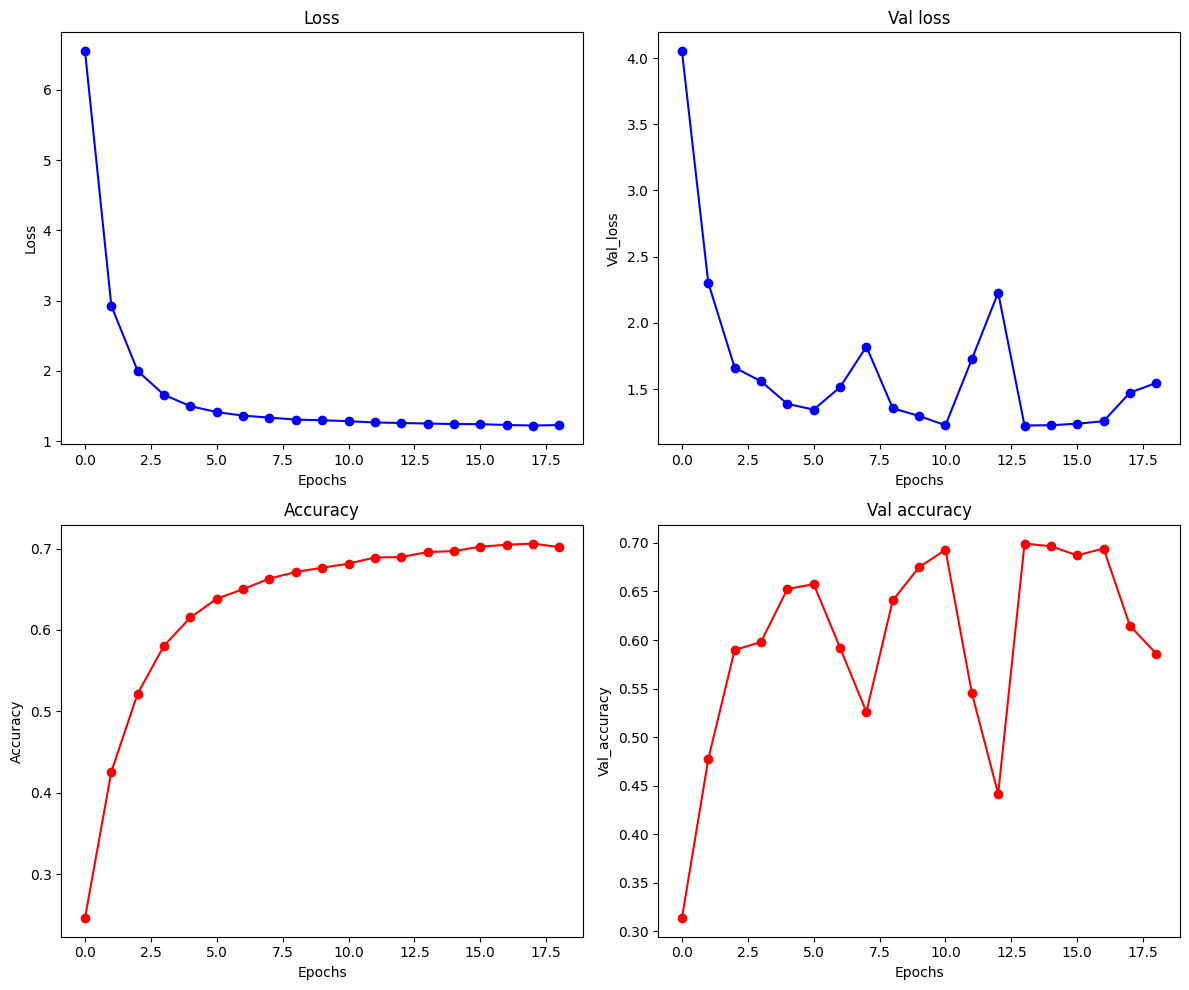

In [ ]:
mostrar_evolucion(history_modelo_3)

Como vemos, hacia el final el modelo estaba empezando claramente a sobreaprender motivo por el cual ha saltado el early stopping. Vamos a aplicar el modelo al conjunto de test ahora para ver que resultados obtiene.

Ahora, vamos a aplicar a test para ver que tan buen resultado da este modelo con CIFAR10.

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = modelo_3.evaluate(X_test_c, y_test_c)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.2344 - accuracy: 0.6969
Test Loss: 1.2344495058059692
Test Accuracy: 0.6969000101089478


No hemos conseguido superar el 70% que dijimos anteriormente, lo cual nos muestra que no parecen haber afectado demasiado los hiperparametros utilizados.

Finalmente, para concluir este ejercicio, vamos a hacer un poco de trampas y hacer data snooping para ver como funcionarian tanto el modelo creado para MNIST como el modelo para CIFAR10 si los aplicamos al conjunto de datos respectivo entero.

Lo que vamos a hacer ***no es correcto***, pues vamos a utilizar el conjunto de test como validacion, cosa que no se deberia  hacer nunca, esto es simplemente un experimento.

In [ ]:
keras.utils.set_random_seed(42)

modelo_mnist_final = crear_modelo_2() # Reseteamos el modelo antes de entrenarlo

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

optimizer = Adadelta(learning_rate=0.3)
modelo_mnist_final.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_modelo_mnist_final = modelo_mnist_final.fit(X_train_recortado, y_train, epochs=40, batch_size=32, verbose=1,
                    validation_data=(X_test_recortado, y_test), shuffle=True, callbacks=[early_stopping])

Epoch 1/40
1875/1875 [==============================] - 13s 6ms/step - loss: 3.5195 - accuracy: 0.8164 - val_loss: 1.1050 - val_accuracy: 0.9764
Epoch 2/40
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6738 - accuracy: 0.9590 - val_loss: 0.3198 - val_accuracy: 0.9816
Epoch 3/40
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2860 - accuracy: 0.9706 - val_loss: 0.1779 - val_accuracy: 0.9858
Epoch 4/40
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2113 - accuracy: 0.9736 - val_loss: 0.1490 - val_accuracy: 0.9870
Epoch 5/40
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1853 - accuracy: 0.9767 - val_loss: 0.1400 - val_accuracy: 0.9871
Epoch 6/40
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1728 - accuracy: 0.9772 - val_loss: 0.1272 - val_accuracy: 0.9880
Epoch 7/40
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1662 - accuracy: 0.9784 - val_loss: 0.1275 - val_ac

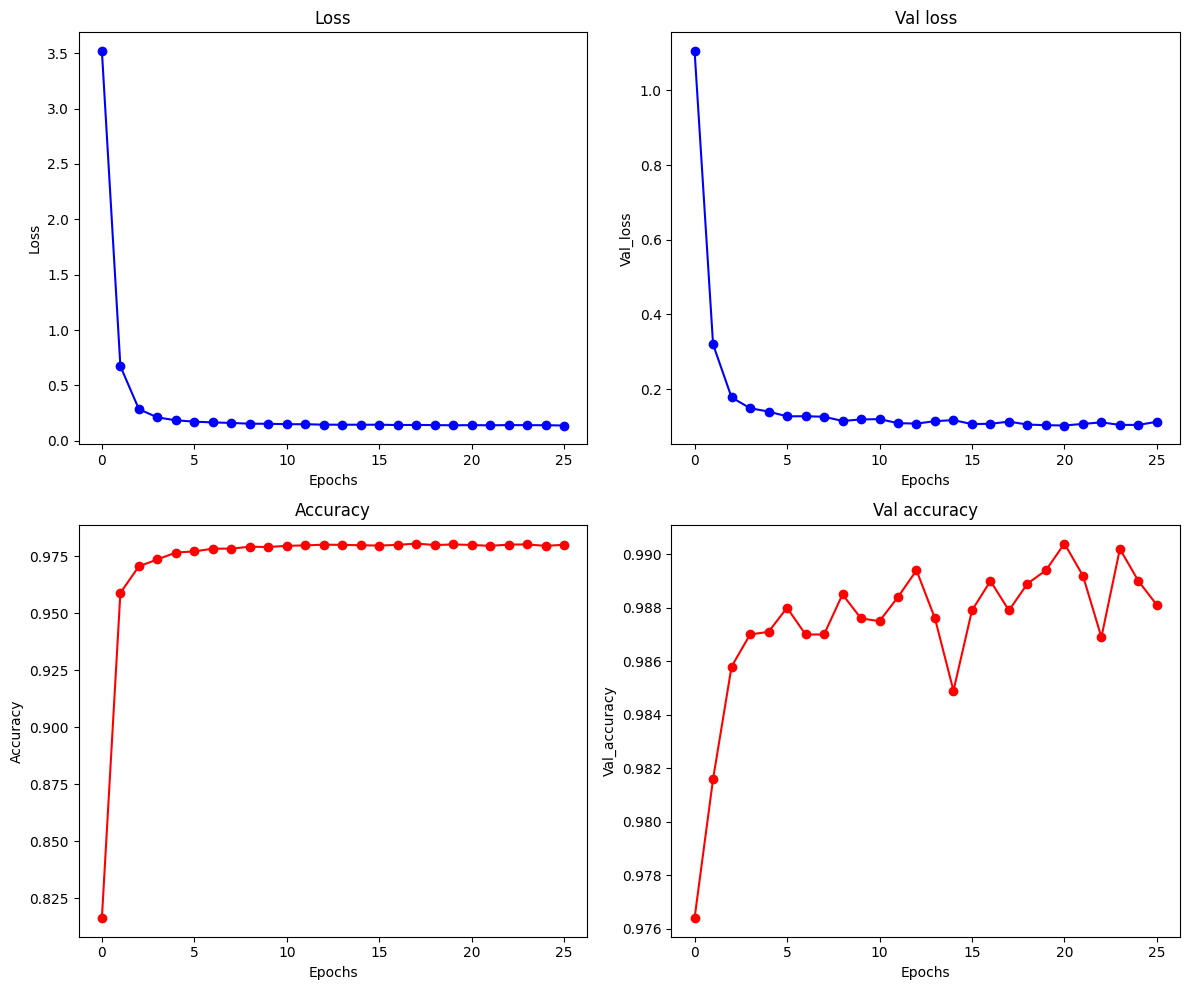

In [ ]:
mostrar_evolucion(history_modelo_mnist_final)

Este modelo ha sido capaz de conseguir un 99% de acc en el test, recordemos que con la aproximacion "clasica" llegabamos a un 80 y pico de accuracy, de nuevo se muestra una vez mas la superioridad de los modelos neuronales en vision por computador.

Realizamos lo mismo exactamente pero con CIFAR10 y los hiperparametros calculados anteriormente.

In [ ]:
keras.utils.set_random_seed(42)

modelo_cifar10_final = crear_modelo_2(input_shape=(32, 32, 3)) # Reseteamos el modelo antes de entrenarlo

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

optimizer = Adadelta(learning_rate=0.3)
modelo_cifar10_final.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_modelo_cifar10_final = modelo_cifar10_final.fit(X_train_c, y_train_c, epochs=30, batch_size=128, verbose=1,
                    validation_data=(X_test_c, y_test_c), shuffle=True, callbacks=[early_stopping])

Epoch 1/30
391/391 [==============================] - 8s 17ms/step - loss: 7.0697 - accuracy: 0.2261 - val_loss: 4.5535 - val_accuracy: 0.4012
Epoch 2/30
391/391 [==============================] - 5s 13ms/step - loss: 3.4673 - accuracy: 0.4034 - val_loss: 2.5210 - val_accuracy: 0.5187
Epoch 3/30
391/391 [==============================] - 5s 13ms/step - loss: 2.2486 - accuracy: 0.5130 - val_loss: 1.8235 - val_accuracy: 0.5953
Epoch 4/30
391/391 [==============================] - 6s 16ms/step - loss: 1.7641 - accuracy: 0.5832 - val_loss: 1.5047 - val_accuracy: 0.6318
Epoch 5/30
391/391 [==============================] - 5s 13ms/step - loss: 1.5204 - accuracy: 0.6210 - val_loss: 1.3649 - val_accuracy: 0.6479
Epoch 6/30
391/391 [==============================] - 5s 12ms/step - loss: 1.3937 - accuracy: 0.6437 - val_loss: 1.3232 - val_accuracy: 0.6569
Epoch 7/30
391/391 [==============================] - 5s 14ms/step - loss: 1.3134 - accuracy: 0.6622 - val_loss: 1.5440 - val_accuracy: 0.5900

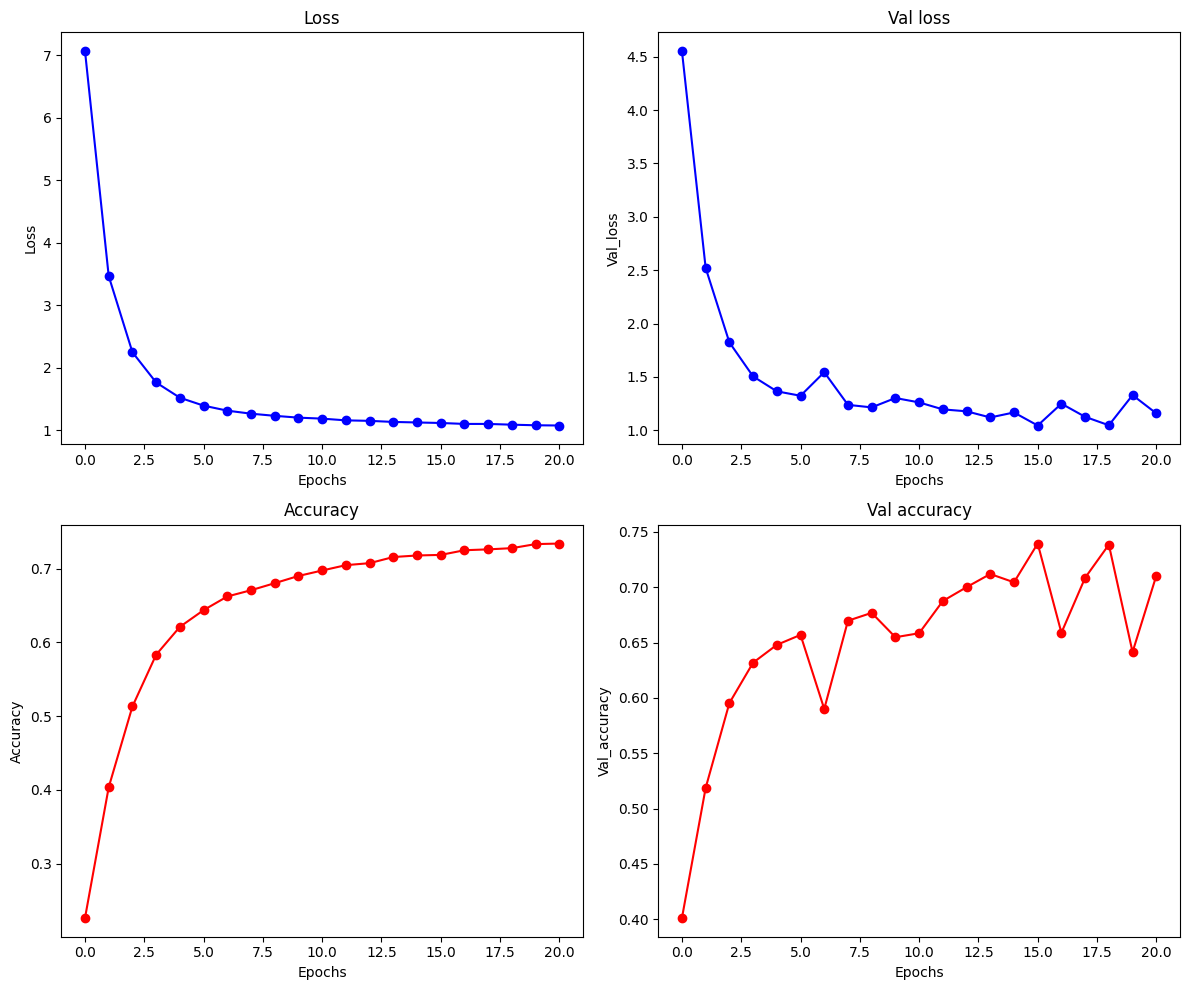

In [ ]:
mostrar_evolucion(history_modelo_cifar10_final)

Cabe destacar que en este caso estamos haciendo trampas, por eso es posible que los resultados sean mejores, pues estamos utilizando primero mas datos para entrenar y segundo, nos estamos quedando con el que mejores resultados da en test habiendo comparado muchos, lo cual no es correcto.


#### Conclusion final:

Lo que podemos destacar de las redes neuronales (concreatamente las convolucionales) es su capacidad para manejar problemas de vision por computador, que es uno de los campos donde claramente destacan por encima del resto de metodos. Aunque no sean perfectas, una de las cosas que hemos visto en este ejercicio es que son muchisimo mas costosas de trabajar con ellas que los metodos clasicos, pero en general, ese coste de tiempo se paga con resultados en los modelos.